## Importing Libraries

In [1]:
#Importing Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
import spacy
import re
import string
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import scikitplot as skplt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score
from sklearn.svm import LinearSVC


from nltk.corpus import stopwords
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
plt.style.use('ggplot')
sns.set_theme(style="whitegrid") # Plotting style
np.random.seed(10) # seeding random number generator

## Data Loading

In [2]:
# configuring path
data_path = '../input/amazon-customerreviews-polarity'
train_data_path = data_path + '/train.csv'
test_data_path = data_path + '/test.csv'
output_path = '../working/'
model_path = output_path + 'model/'
output_file_path = output_path + 'file/'
!mkdir "$model_path"
!mkdir "$output_file_path"
cleaned_train_input_file_path = output_file_path + '/train_clean.csv'
cleaned_test_input_file_path = output_file_path + '/test_clean.csv'

In [3]:
# data loading
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# column addition
train_df.columns = ['polarity','title','text']
test_df.columns = ['polarity','title','text']

In [4]:
train_df.head(10)

,polarity,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...
5,1,Buyer beware,"This is a self-published book, and if you want..."
6,2,Glorious story,I loved Whisper of the wicked saints. The stor...
7,2,A FIVE STAR BOOK,I just finished reading Whisper of the Wicked ...
8,2,Whispers of the Wicked Saints,This was a easy to read book that made me want...
9,1,The Worst!,A complete waste of time. Typographical errors...


## Data Wrangling

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int64 
 1   title     object
 2   text      object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [6]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating == 1: # negative
        return 0
    elif rating == 2: # Positive
        return 1
    else:
        return 3

# Apply to the dataset 
train_df['polarity'] = train_df.polarity.apply(to_sentiment)
test_df['polarity'] = test_df.polarity.apply(to_sentiment)

In [7]:
# printing label counts
train_df['polarity'].value_counts()

0    1800000
1    1799999
Name: polarity, dtype: int64

In [8]:
# Let's check for missing values in train data
print('---------Training Data-----------')
print(train_df.isnull().sum())

# Let's check for missing values in test data
print('---------Test Data-----------')
print(test_df.isnull().sum())

---------Training Data-----------
polarity     0
title       77
text         0
dtype: int64
---------Test Data-----------
polarity     0
title       10
text         0
dtype: int64


In [9]:
# Substituting Null values with empty spaces
train_df['title'] = train_df['title'].fillna(' ')
test_df['title'] = test_df['title'].fillna(' ')

# Let's check for missing values in train data
print('---------Training Data-----------')
print(train_df.isnull().sum())

# Let's check for missing values in test data
print('---------Test Data-----------')
print(test_df.isnull().sum())

---------Training Data-----------
polarity    0
title       0
text        0
dtype: int64
---------Test Data-----------
polarity    0
title       0
text        0
dtype: int64


### Data Cleaning

In [10]:
# Load the SpaCy English model
# Since we are not using NER, we can disable it to speedup
nlp = spacy.load("en_core_web_sm", disable='ner')

In [11]:
abbreviations = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
     "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
    "who'd": "who would",
    "who're": "who are",
    "'re": " are",
    "tryin'": "trying",
    "doesn'": "does not",
    'howdo': 'how do',
    'whatare': 'what are',
    'howcan': 'how can',
    'howmuch': 'how much',
    'howmany': 'how many',
    'whydo': 'why do',
    'doI': 'do I',
    'theBest': 'the best',
    'howdoes': 'how does',
}

In [13]:
def clean_lower(df,col):
    df[col] = df[col].apply(lambda x: x.lower())
    return df

def clean_punctuation(df,col):
    df[col] = df[col].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return df

def clean_abbreviation(df, abbreviations,col):
    compiled_re = re.compile('(%s)' % '|'.join(abbreviations.keys()))
    def replace(match):
        return abbreviations[match.group(0)]
    df[col] = df[col].apply(
        lambda x: compiled_re.sub(replace, x)
    )
    return df

def clean_space(df,col):
    compiled_re = re.compile(r"\s+")
    df[col] = df[col].apply(lambda x: compiled_re.sub(" ", x))
    return df

def clean_repeated_words(df,col):
    df[col] = df[col].apply(lambda x: re.sub(r'\b(\w+\s*)\1{1,}', '\\1', x))
    return df

def clean_url_expression(df,col):
    compiled_re = re.compile(r'https?://\S+|www\.\S+')
    df[col] = df[col].apply(lambda x : compiled_re.sub(r" ",x))
    return df
    
def clean_html_expression(df,col):
    compiled_re = re.compile(r'<.*?>')
    df[col] = df[col].apply(lambda x : compiled_re.sub(r" ",x))
    return df
    
def clean_emoji_expression(df,col):
    compiled_re = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
    df[col] = df[col].apply(lambda x : compiled_re.sub(r" ",x))
    return df

def clean_stopwords_and_lemmatize(df,col):
    df[col] = df[col].apply(_clean_stopwords_and_lemmatize)
    return df

def _clean_stopwords_and_lemmatize(texts):
    # lemmatize the tokens and store them in a list
    lemmatized_tokens = [token.lemma_ for token in nlp(texts) if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        
    # Join the lemmatized tokens into a string
    return" ".join(lemmatized_tokens)

def clean_math(df,col):
    math_puncts = 'θπα÷⁴≠β²¾∫≥⇒¬∠＝∑Φ√½¼'
    math_puncts_long = [r'\\frac', r'\[math\]', r'\[/math\]', r'\\lim']
    compiled_math = re.compile('(%s)' % '|'.join(math_puncts))
    compiled_math_long = re.compile('(%s)' % '|'.join(math_puncts_long))
    df[col] = df[col].apply(lambda x: _clean_math(x, compiled_math_long))
    df[col] = df[col].apply(lambda x: _clean_math(x, compiled_math))
    return df

def _clean_math(x, compiled_re):
    return compiled_re.sub(' <math> ', x)

In [14]:
def clean(df,col): 
    print('Data Cleaning Started')
    print('##########################')
    df = clean_lower(df,col)
    print('Lower Cleaning Done..')
    df = clean_abbreviation(df, abbreviations,col)
    print('Abbreviation Cleaning Done..')
    df = clean_punctuation(df,col)
    print('Punctuation Cleaning Done..')
    df = clean_math(df,col)
    print('Math Cleaning Done..')
    df = clean_url_expression(df,col)
    print('Url Cleaning Done..')
    df = clean_html_expression(df,col)
    print('Html Expression Cleaning Done..')
    df = clean_emoji_expression(df,col)
    print('Emoji Expression Cleaning Done..')
    df = clean_stopwords_and_lemmatize(df,col)
    print('Stop Word Cleaning Done..')
    df = clean_space(df,col)
    print('Space Cleaning Done..')
    print('#############################')
    print('Data Cleaning Finished.')
    return df

In [15]:
train_df['review'] = train_df['title'].astype(str) + ' ' + train_df['text'].astype(str)
test_df['review'] = test_df['title'].astype(str) + ' ' + test_df['text'].astype(str)

print('---------Training Data Shape-----------')
print(train_df.shape)

print('---------Test Data Shape-----------')
print(test_df.shape)

---------Training Data Shape-----------
(3599999, 4)
---------Test Data Shape-----------
(399999, 4)


In [16]:
# Randomly sample 10K elements from your dataframe
train_df = train_df.sample(n=10000)
test_df = test_df.sample(n=500)
print(train_df.shape,train_df.shape)
print(test_df.shape,test_df.shape)

(10000, 4) (10000, 4)
(500, 4) (500, 4)


In [17]:
# cleaning train data
train_df_clean = clean(train_df,col='review')

# Saving the cleaned file
train_df_clean.to_csv(cleaned_train_input_file_path,index=False)

Data Cleaning Started
##########################
Lower Cleaning Done..
Abbreviation Cleaning Done..
Punctuation Cleaning Done..
Math Cleaning Done..
Url Cleaning Done..
Html Expression Cleaning Done..
Emoji Expression Cleaning Done..
Stop Word Cleaning Done..
Space Cleaning Done..
#############################
Data Cleaning Finished.


In [18]:
# Seeing Cleaned Data
train_df_clean.head(5)

,polarity,title,text,review
818727,0,Wolves BluRay,This film was absolutely terrible. For most of...,wolf bluray film absolutely terrible film watc...
673354,0,o.k.,I think Tori Amos is a very talented artist. T...,ok I think tori amos talented artist collectio...
2952780,1,"Great, clean romance",I am always looking for books like this with a...,great clean romance I look book like suspensef...
2275972,0,MY DISCOUNT MEDIA,I bought Modern Drummer festival 1997.It was w...,discount medium I buy modern drummer festival ...
2093106,1,Great service,It was a smooth and speedy transaction. The pa...,great service smooth speedy transaction packag...


In [19]:
# cleaning test data
test_df_clean = clean(test_df,col='review')

# Saving the cleaned file
test_df_clean.to_csv(cleaned_test_input_file_path,index=False)

Data Cleaning Started
##########################
Lower Cleaning Done..
Abbreviation Cleaning Done..
Punctuation Cleaning Done..
Math Cleaning Done..
Url Cleaning Done..
Html Expression Cleaning Done..
Emoji Expression Cleaning Done..
Stop Word Cleaning Done..
Space Cleaning Done..
#############################
Data Cleaning Finished.


In [20]:
# Seeing Cleaned Data
test_df_clean.head(5)

,polarity,title,text,review
426,1,one more positive note,Don't know if anyone else has addresed this. I...,positive note know addrese I build barn shop y...
323870,1,rEvIeW,"Excellent overall quality, timely shipping, ju...",review excellent overall quality timely ship g...
320315,0,wish i could've read it...,but after putting this on my wish list and fin...,wish I read wish list finally receive realize ...
328943,0,Auto Shut Off does not work,The iron automatically shut off four times whi...,auto shut work iron automatically shut time I ...
75287,0,"Lots of beauty, absolutely no chemistry","What a disappointment this was. I thought, wit...",lot beauty absolutely chemistry disappointment...


## Data Visualization

In [48]:
#Some new columns for data exploration
train_df['review_content_len'] = train_df['text'].astype(str).apply(len)
train_df['review_title_len'] = train_df['title'].astype(str).apply(len)
train_df['content_word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
train_df['title_word_count'] = train_df['title'].apply(lambda x: len(str(x).split()))

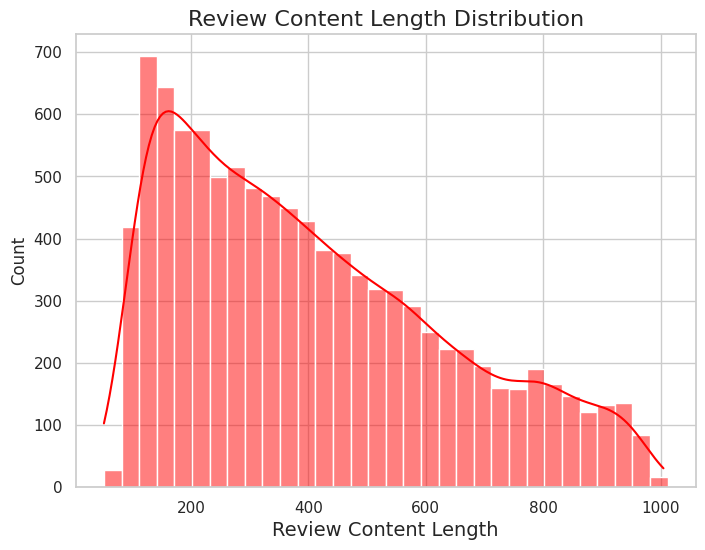

In [49]:
#Plot the distribution
plt.figure(figsize=(8,6),dpi=100)
sns.histplot(data=train_df, x="review_content_len",binwidth=30,color='red',kde=True)
plt.title('Review Content Length Distribution', fontsize=16)
plt.xlabel('Review Content Length', fontsize=14) 
plt.show()
plt.close()

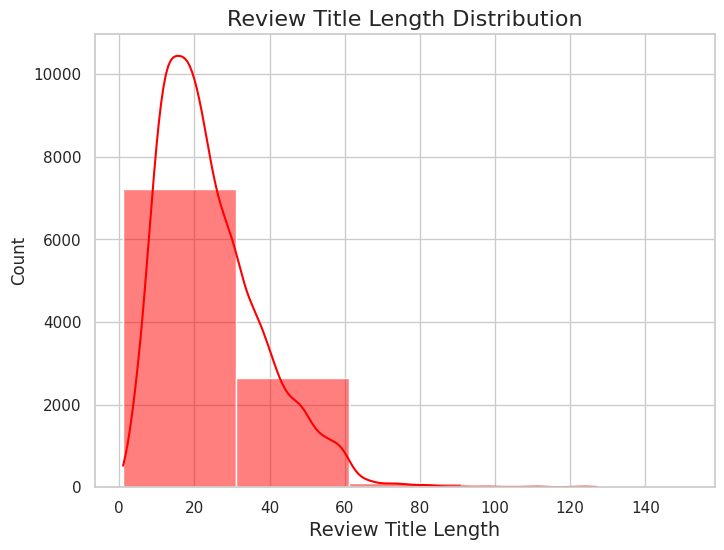

In [50]:
#Plot the distribution
plt.figure(figsize=(8,6),dpi=100)
sns.histplot(data=train_df, x="review_title_len",binwidth=30,color='red',kde=True)
plt.title('Review Title Length Distribution', fontsize=16)
plt.xlabel('Review Title Length', fontsize=14) 
plt.show()
plt.close()

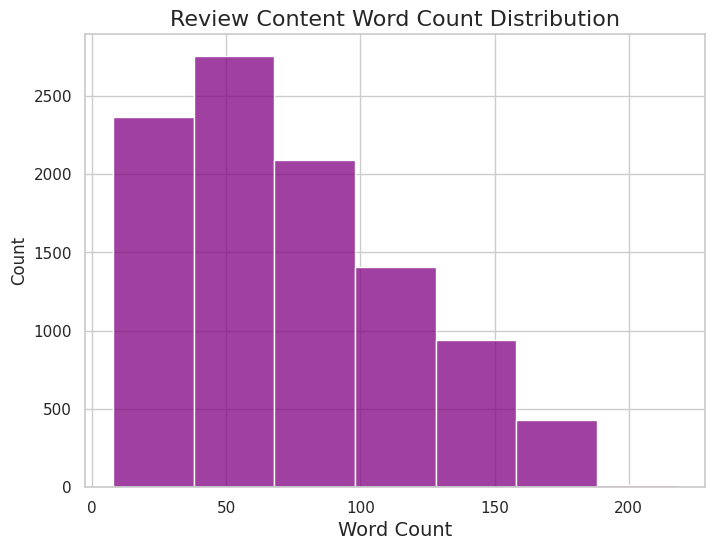

In [51]:
plt.figure(figsize=(8,6),dpi=100)
sns.histplot(data=train_df, x="content_word_count",binwidth=30,color='purple')
plt.title('Review Content Word Count Distribution', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.show()
plt.close()

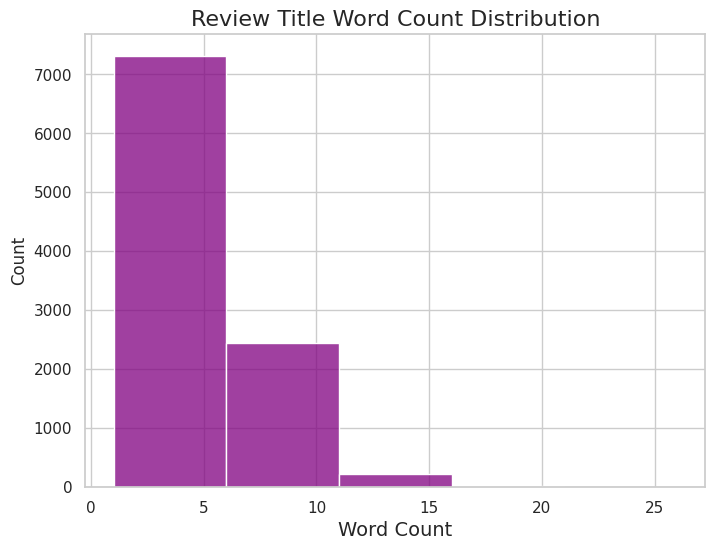

In [52]:
plt.figure(figsize=(8,6),dpi=100)
sns.histplot(data=train_df, x="title_word_count",binwidth=5,color='purple')
plt.title('Review Title Word Count Distribution', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.show()
plt.close()

## Data Preparation

In [21]:
# loading cleaned train input file path
train_df_clean = pd.read_csv(cleaned_train_input_file_path)
test_df_clean = pd.read_csv(cleaned_test_input_file_path)

# Separating out independent and dependent columns
X_train = train_df_clean.drop(['polarity'],axis = 1)
Y_train = train_df_clean.drop(['title','text','review'],axis = 1)
X_test = test_df.drop(['polarity'],axis = 1)
Y_test = test_df.drop(['title','text','review'],axis = 1)

In [22]:
X_train = X_train.drop(['title','text'],axis = 1)
print(X_train.shape,Y_train.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.33, random_state=4, stratify=Y_train)

(10000, 1) (10000, 1)


In [23]:
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_val, return_counts=True))

(array([0, 1]), array([3318, 3382]))
(array([0, 1]), array([1634, 1666]))


### Performance Evaluation

In [24]:
def report(model,X,Y,modelName,report_type,accuracy_scores,auc_scores):
    YPred = model.predict(X)
    if report_type == 'Training':
        print(f"{modelName} Training Data Result:\n================================================")
    elif report_type == 'Validation':
        print(f"{modelName} Validation Data Result:\n================================================")
    else:
        print(f"{modelName} Test Data Result:\n================================================")
    model_accuracy_score = accuracy_score(Y, YPred) * 100
    model_auc_score = roc_auc_score(Y, YPred) * 100
    print(f"Accuracy Score: {model_accuracy_score:.2f}%")
    print(f"AUC Score: {model_auc_score:.2f}%")
    print("_______________________________________________")
    clf_report = pd.DataFrame(classification_report(Y, YPred, output_dict=True))
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    skplt.metrics.plot_confusion_matrix(Y, YPred)
    accuracy_scores.append(model_accuracy_score)
    auc_scores.append(model_auc_score)

# Vectorization

## One Hot Encoding Vectorizer

In [25]:
count_vectorizer_ohe = CountVectorizer(min_df=0.001, binary=True)
#fit_transform user_review
count_vectorizer_ohe_train = count_vectorizer_ohe.fit_transform(X_train['review'])

Bernouli NB Model Training Data Result:
Accuracy Score: 87.12%
AUC Score: 87.11%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.878975     0.863912  0.871194     0.871444      0.871372
recall        0.858047     0.884092  0.871194     0.871070      0.871194
f1-score      0.868385     0.873886  0.871194     0.871135      0.871162
support    3318.000000  3382.000000  0.871194  6700.000000   6700.000000


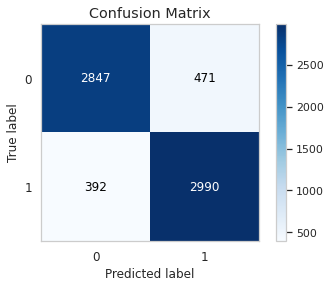

In [26]:
# Naive Bayes Classifier
naive_bayes_classifier = BernoulliNB()

#create the naive bayes model for the train data
naive_bayes_classifier.fit(count_vectorizer_ohe_train, Y_train['polarity'])
# initializing scores list
training_accuracy_scores = []
training_auc_scores = []
report(naive_bayes_classifier,count_vectorizer_ohe_train,Y_train['polarity'],'Bernouli NB Model','Training',training_accuracy_scores,training_auc_scores)
# naive_bayes_classifier.score(count_vectorizer_ohe_train, Y_train['polarity'])

Bernouli NB Model Validation Data Result:
Accuracy Score: 81.70%
AUC Score: 81.67%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.831403     0.804124   0.81697     0.817763      0.817631
recall        0.790698     0.842737   0.81697     0.816717      0.816970
f1-score      0.810540     0.822978   0.81697     0.816759      0.816819
support    1634.000000  1666.000000   0.81697  3300.000000   3300.000000


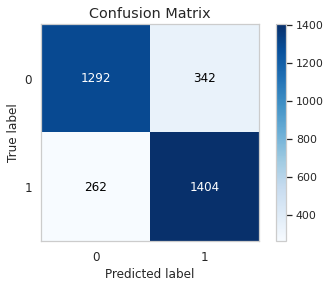

In [27]:
##create the naive bayes model for the validation data
count_vectorizer_ohe_val = count_vectorizer_ohe.transform(X_val['review'])
# initializing scores list
validation_accuracy_scores = []
validation_auc_scores = []
report(naive_bayes_classifier,count_vectorizer_ohe_val,Y_val['polarity'],'Bernouli NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

Multinomial NB Model Training Data Result:
Accuracy Score: 87.33%
AUC Score: 87.32%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.875342     0.871299  0.873284     0.873320      0.873301
recall        0.867691     0.878770  0.873284     0.873231      0.873284
f1-score      0.871500     0.875018  0.873284     0.873259      0.873276
support    3318.000000  3382.000000  0.873284  6700.000000   6700.000000


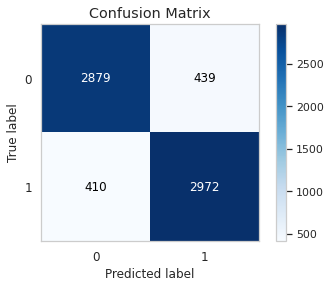

In [28]:
# Multinomial Naive Bayes Classifier
multi_naive_bayes_classifier = MultinomialNB()

#create the naive bayes model for the train data
multi_naive_bayes_classifier.fit(count_vectorizer_ohe_train, Y_train['polarity'])
report(multi_naive_bayes_classifier,count_vectorizer_ohe_train,Y_train['polarity'],'Multinomial NB Model','Training',training_accuracy_scores,training_auc_scores)

Multinomial NB Model Validation Data Result:
Accuracy Score: 81.00%
AUC Score: 80.98%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.818469     0.802211      0.81     0.810340      0.810261
recall        0.791922     0.827731      0.81     0.809826      0.810000
f1-score      0.804977     0.814771      0.81     0.809874      0.809921
support    1634.000000  1666.000000      0.81  3300.000000   3300.000000


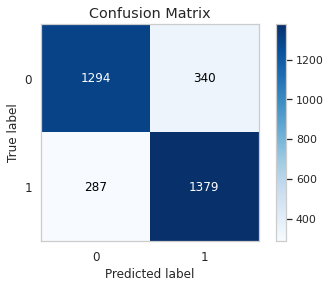

In [29]:
# Multinomial Validation Model
# initializing scores list
report(multi_naive_bayes_classifier,count_vectorizer_ohe_val,Y_val['polarity'],'Multinomial NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [30]:
# Logistic Regression Training Model
params = {
              'logisticregression__C': [0.1, 1, 10],
              }
log_reg_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('logisticregression', LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))])
log_reg_model_cv = GridSearchCV(log_reg_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
log_reg_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
bestParams = log_reg_model_cv.best_params_
print(f"Logistic Regression Model Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression Model Best paramters: {'logisticregression__C': 0.1})


Logistic Regression Model Training Data Result:
Accuracy Score: 99.90%
AUC Score: 99.89%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.999698     0.998229  0.998955     0.998963      0.998956
recall        0.998192     0.999704  0.998955     0.998948      0.998955
f1-score      0.998944     0.998966  0.998955     0.998955      0.998955
support    3318.000000  3382.000000  0.998955  6700.000000   6700.000000


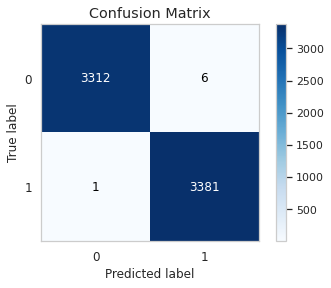

In [31]:
report(log_reg_model_cv,count_vectorizer_ohe_train,Y_train['polarity'],'Logistic Regression Model','Training',training_accuracy_scores,training_auc_scores)

Logistic Regression Model Validation Data Result:
Accuracy Score: 75.94%
AUC Score: 75.93%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.761845     0.757075  0.759394     0.759460      0.759437
recall        0.747858     0.770708  0.759394     0.759283      0.759394
f1-score      0.754787     0.763831  0.759394     0.759309      0.759353
support    1634.000000  1666.000000  0.759394  3300.000000   3300.000000


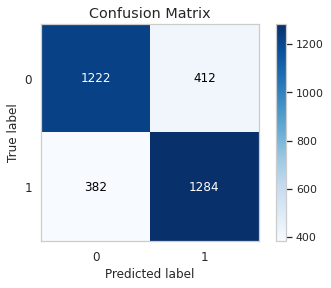

In [32]:
report(log_reg_model_cv,count_vectorizer_ohe_val,Y_val['polarity'],'Logistic Regression Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [33]:
# SVM Training Model
#Hyperparameter Tuning [New Addition]
params = {
              'linearsvm__C': [0.1, 1, 10],
              }
linear_svc_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('linearsvm', LinearSVC(tol=1e-5))])
linear_svc_model_cv = GridSearchCV(linear_svc_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
linear_svc_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
bestParams = linear_svc_model_cv.best_params_
print(f"Linear SVM Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Linear SVM Best paramters: {'linearsvm__C': 0.1})


Linear SVM Model Training Data Result:
Accuracy Score: 100.00%
AUC Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    3318.0  3382.0       1.0     6700.0        6700.0


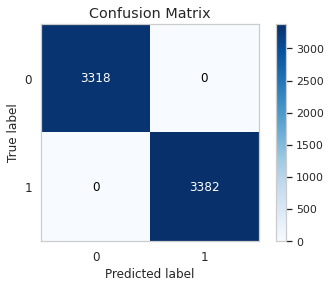

In [34]:
report(linear_svc_model_cv,count_vectorizer_ohe_train,Y_train['polarity'],'Linear SVM Model','Training',training_accuracy_scores,training_auc_scores)

Linear SVM Model Validation Data Result:
Accuracy Score: 73.91%
AUC Score: 73.89%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.745709     0.733063  0.739091     0.739386      0.739325
recall        0.717870     0.759904  0.739091     0.738887      0.739091
f1-score      0.731525     0.746242  0.739091     0.738884      0.738955
support    1634.000000  1666.000000  0.739091  3300.000000   3300.000000


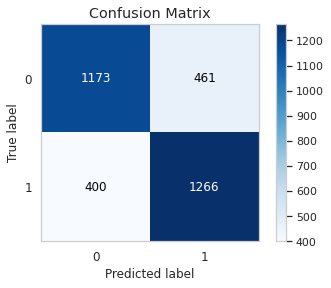

In [35]:
report(linear_svc_model_cv,count_vectorizer_ohe_val,Y_val['polarity'],'Linear SVM Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [36]:
# Descision Tree Classifier
#Finding Best Hyperparameter For Decision Tree [New Addition]
params = {
 'decisiontreeclassifier__max_depth': [10,15,20],
 'decisiontreeclassifier__min_samples_split': [2,4,6],
 'decisiontreeclassifier__min_samples_leaf':[100,200,300]
}
# Checking If Model Exist then load it.
decision_tree_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('decisiontreeclassifier', DecisionTreeClassifier())])
decision_tree_model_cv = GridSearchCV(decision_tree_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
decision_tree_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
bestParams = decision_tree_model_cv.best_params_
print(f"Decision Tree Best paramters: {bestParams})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree Best paramters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 100, 'decisiontreeclassifier__min_samples_split': 2})


Decision Tree Model Training Data Result:
Accuracy Score: 69.97%
AUC Score: 69.98%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.693081     0.706450  0.699701     0.699765      0.699829
recall        0.706450     0.693081  0.699701     0.699765      0.699701
f1-score      0.699701     0.699701  0.699701     0.699701      0.699701
support    3318.000000  3382.000000  0.699701  6700.000000   6700.000000


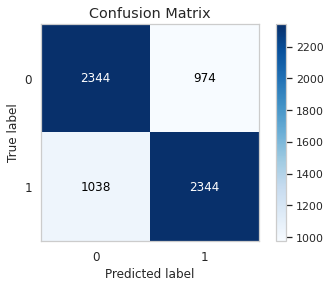

In [37]:
report(decision_tree_model_cv,count_vectorizer_ohe_train,Y_train['polarity'],'Decision Tree Model','Training',training_accuracy_scores,training_auc_scores)

Decision Tree Model Validation Data Result:
Accuracy Score: 69.82%
AUC Score: 69.85%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.682913     0.715296  0.698182     0.699104      0.699261
recall        0.728886     0.668067  0.698182     0.698477      0.698182
f1-score      0.705151     0.690875  0.698182     0.698013      0.697944
support    1634.000000  1666.000000  0.698182  3300.000000   3300.000000


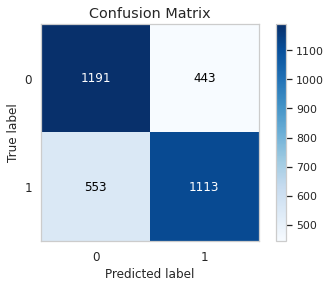

In [38]:
report(decision_tree_model_cv,count_vectorizer_ohe_val,Y_val['polarity'],'Decision Tree Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [39]:
#Finding Best Hyperparameter For Random Forest [New Addition]
params = {
 'randomforestclassifier__max_depth': [10,15,20],
 'randomforestclassifier__min_samples_split': [2,4,6],
 'randomforestclassifier__min_samples_leaf':[100,200,300]
}
rf_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=4,min_samples_leaf=300))])
rf_model_cv = GridSearchCV(rf_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
rf_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
rf_best_params = rf_model_cv.best_params_
print(f"Random Forest Best paramters: {rf_best_params})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest Best paramters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__min_samples_split': 4})


Random Forest Model Training Data Result:
Accuracy Score: 75.60%
AUC Score: 75.56%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.772948     0.741498   0.75597     0.757223      0.757073
recall        0.718204     0.793022   0.75597     0.755613      0.755970
f1-score      0.744571     0.766395   0.75597     0.755483      0.755587
support    3318.000000  3382.000000   0.75597  6700.000000   6700.000000


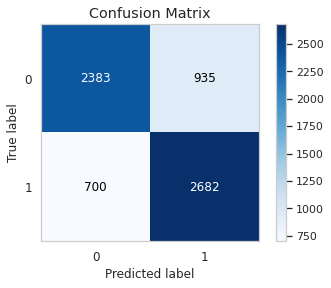

In [40]:
report(rf_model_cv,count_vectorizer_ohe_train,Y_train['polarity'],'Random Forest Model','Training',training_accuracy_scores,training_auc_scores)

Random Forest Model Validation Data Result:
Accuracy Score: 74.36%
AUC Score: 74.34%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.750955     0.736994  0.743636     0.743975      0.743907
recall        0.721542     0.765306  0.743636     0.743424      0.743636
f1-score      0.735955     0.750883  0.743636     0.743419      0.743492
support    1634.000000  1666.000000  0.743636  3300.000000   3300.000000


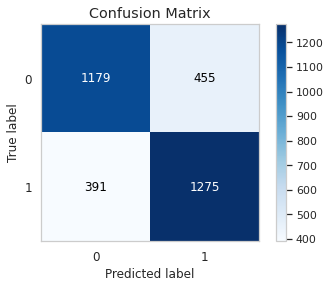

In [41]:
report(rf_model_cv,count_vectorizer_ohe_val,Y_val['polarity'],'Random Forest Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [44]:
def create_barplot(df,x_label,y_label,x_col,y_col,filename):
    plt.figure(figsize=(12,6),dpi=100)
    plt.style.use('ggplot')
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x_col,y=y_col,data=df,palette="Set2")

    for bar in ax.patches:
      ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')

    ax.set(xlabel=x_label, ylabel=y_label)
    ax.tick_params(axis='x', rotation=30)
    plt.setp(ax.patches, linewidth=0)
    # plt.legend(title = 'Team Name', bbox_to_anchor=(1, 1))
    plt.show()

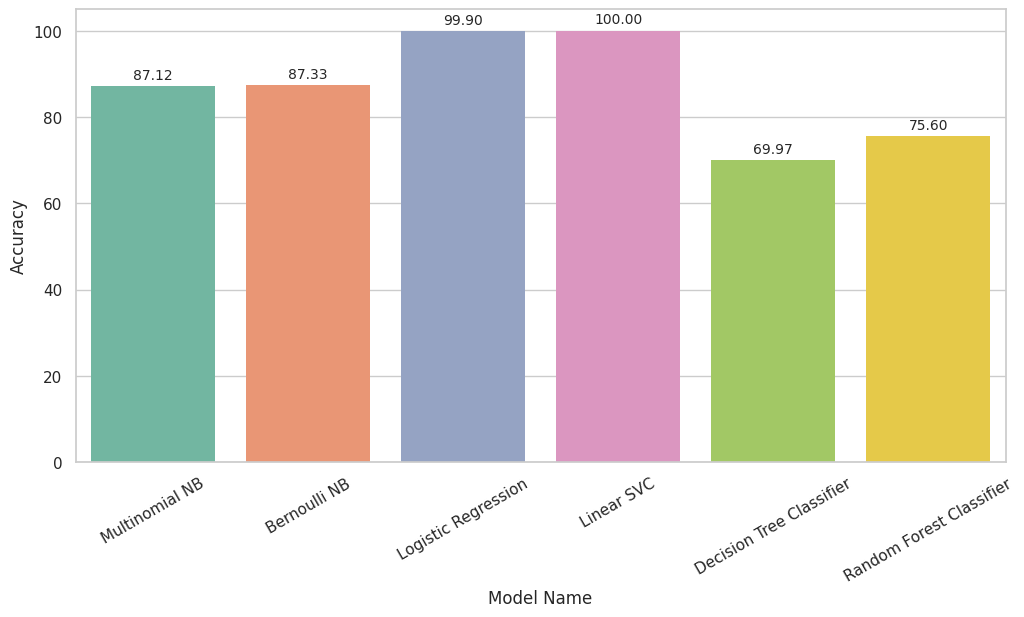

In [45]:
model_name_list = ['Multinomial NB','Bernoulli NB','Logistic Regression','Linear SVC','Decision Tree Classifier','Random Forest Classifier']
df_train = pd.DataFrame(model_name_list,columns=['model_name'])
df_train['accuracy_score'] = training_accuracy_scores
df_val = pd.DataFrame(model_name_list,columns=['model_name'])
df_val['accuracy_score'] = validation_accuracy_scores
create_barplot(df_train,'Model Name','Accuracy','model_name','accuracy_score','ohe_train_accuracy')

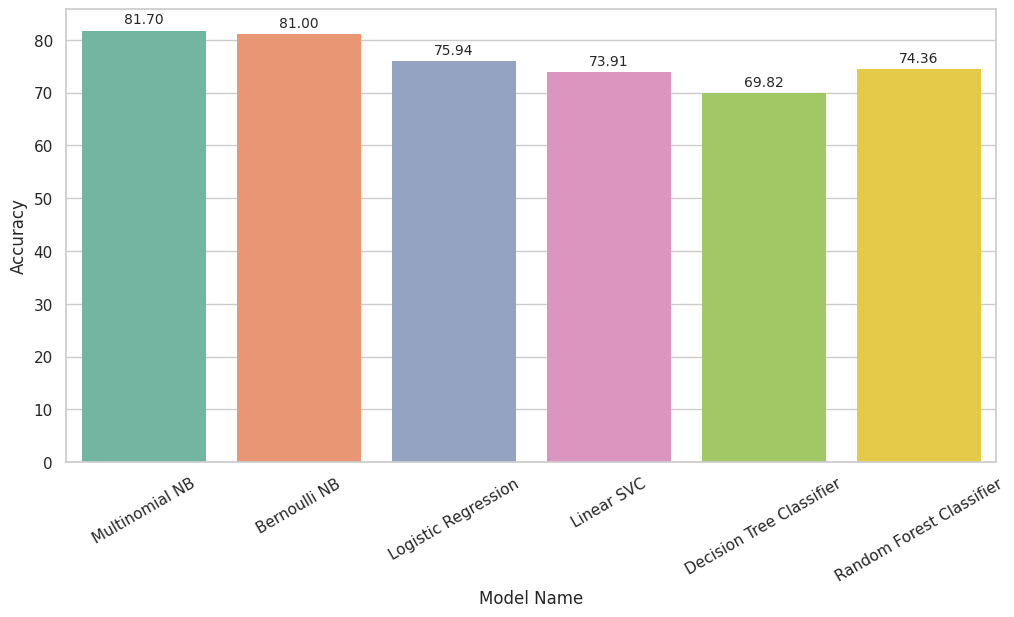

In [46]:
create_barplot(df_val,'Model Name','Accuracy','model_name','accuracy_score','ohe_val_accuracy')

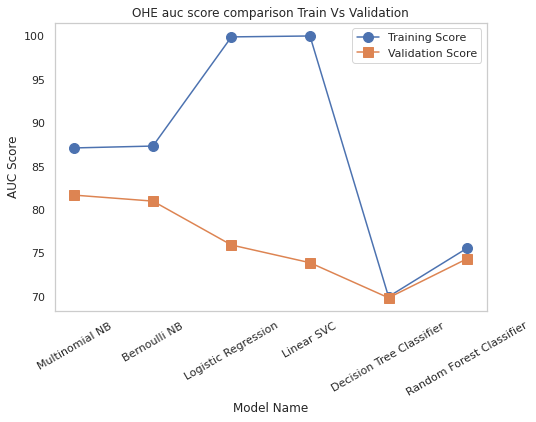

In [48]:
#Creating Canvas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_ylabel('AUC Score')
ax.set_xlabel('Model Name')
ax.set_title('OHE auc score comparison Train Vs Validation')

#Creating Multiline Plot
ax.plot(model_name_list,training_auc_scores, label="Training Score",marker='o',ms=10)
ax.plot(model_name_list,validation_auc_scores, label="Validation Score",marker='s',ms=10)

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
ax.tick_params(axis='x', rotation=30)
plt.show()
plt.close()

## Count Vectorizer

In [49]:
# initialize count_vectorizer and name it count_vectorizer
count_vectorizer = CountVectorizer(min_df=0.001)
#fit_transform user_review
count_vectorizer_train = count_vectorizer.fit_transform(X_train['review'])
count_vectorizer_val = count_vectorizer.transform(X_val['review'])

Bernouli NB Model Training Data Result:
Accuracy Score: 87.12%
AUC Score: 87.11%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.878975     0.863912  0.871194     0.871444      0.871372
recall        0.858047     0.884092  0.871194     0.871070      0.871194
f1-score      0.868385     0.873886  0.871194     0.871135      0.871162
support    3318.000000  3382.000000  0.871194  6700.000000   6700.000000


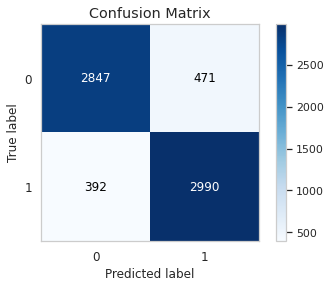

In [50]:
# Naive Bayes Classifier
naive_bayes_classifier = BernoulliNB()

#create the naive bayes model for the train data
naive_bayes_classifier.fit(count_vectorizer_train, Y_train['polarity'])
# initializing scores list
training_accuracy_scores = []
training_auc_scores = []
report(naive_bayes_classifier,count_vectorizer_train,Y_train['polarity'],'Bernouli NB Model','Training',training_accuracy_scores,training_auc_scores)

Bernouli NB Model Validation Data Result:
Accuracy Score: 81.70%
AUC Score: 81.67%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.831403     0.804124   0.81697     0.817763      0.817631
recall        0.790698     0.842737   0.81697     0.816717      0.816970
f1-score      0.810540     0.822978   0.81697     0.816759      0.816819
support    1634.000000  1666.000000   0.81697  3300.000000   3300.000000


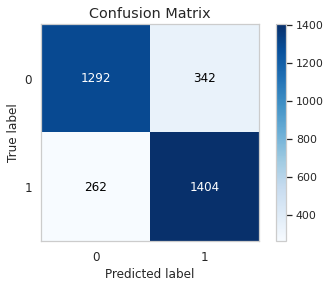

In [51]:
##create the naive bayes model for the validation data
# initializing scores list
validation_accuracy_scores = []
validation_auc_scores = []
report(naive_bayes_classifier,count_vectorizer_val,Y_val['polarity'],'Bernouli NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

Multinomial NB Model Training Data Result:
Accuracy Score: 87.16%
AUC Score: 87.15%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.876994     0.866570  0.871642     0.871782      0.871732
recall        0.861664     0.881431  0.871642     0.871547      0.871642
f1-score      0.869261     0.873937  0.871642     0.871599      0.871622
support    3318.000000  3382.000000  0.871642  6700.000000   6700.000000


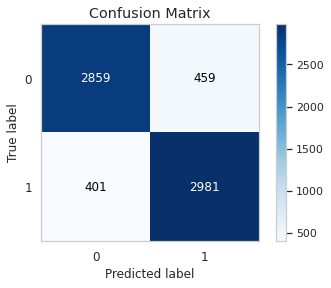

In [52]:
# Multinomial Naive Bayes Classifier
multi_naive_bayes_classifier = MultinomialNB()

#create the naive bayes model for the train data
multi_naive_bayes_classifier.fit(count_vectorizer_train, Y_train['polarity'])
report(multi_naive_bayes_classifier,count_vectorizer_train,Y_train['polarity'],'Multinomial NB Model','Training',training_accuracy_scores,training_auc_scores)

Multinomial NB Model Validation Data Result:
Accuracy Score: 79.94%
AUC Score: 79.92%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.809949     0.789838  0.799394     0.799894      0.799796
recall        0.777234     0.821128  0.799394     0.799181      0.799394
f1-score      0.793254     0.805180  0.799394     0.799217      0.799275
support    1634.000000  1666.000000  0.799394  3300.000000   3300.000000


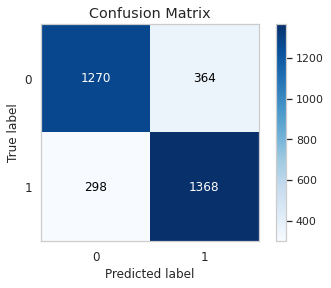

In [53]:
# Multinomial Validation Model
# initializing scores list
report(multi_naive_bayes_classifier,count_vectorizer_val,Y_val['polarity'],'Multinomial NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [54]:
# Logistic Regression Training Model
params = {
              'logisticregression__C': [0.1, 1, 10],
              }
log_reg_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('logisticregression', LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))])
log_reg_model_cv = GridSearchCV(log_reg_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
log_reg_model_cv.fit(count_vectorizer_train, Y_train['polarity'])
bestParams = log_reg_model_cv.best_params_
print(f"Logistic Regression Model Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression Model Best paramters: {'logisticregression__C': 0.1})


Logistic Regression Model Training Data Result:
Accuracy Score: 99.85%
AUC Score: 99.85%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.999095     0.997933  0.998507     0.998514      0.998508
recall        0.997890     0.999113  0.998507     0.998502      0.998507
f1-score      0.998492     0.998522  0.998507     0.998507      0.998507
support    3318.000000  3382.000000  0.998507  6700.000000   6700.000000


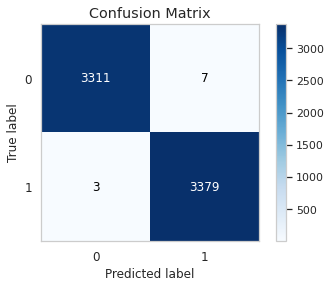

In [55]:
report(log_reg_model_cv,count_vectorizer_train,Y_train['polarity'],'Logistic Regression Model','Training',training_accuracy_scores,training_auc_scores)

Logistic Regression Model Validation Data Result:
Accuracy Score: 76.15%
AUC Score: 76.15%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.758705     0.764281  0.761515     0.761493      0.761520
recall        0.760098     0.762905  0.761515     0.761502      0.761515
f1-score      0.759401     0.763593  0.761515     0.761497      0.761517
support    1634.000000  1666.000000  0.761515  3300.000000   3300.000000


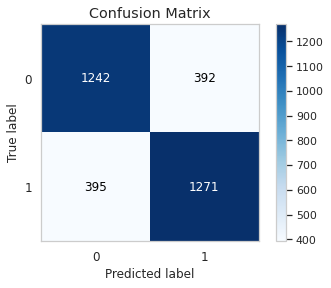

In [56]:
report(log_reg_model_cv,count_vectorizer_val,Y_val['polarity'],'Logistic Regression Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [57]:
# SVM Training Model
#Hyperparameter Tuning [New Addition]
params = {
              'linearsvm__C': [0.1, 1, 10],
              }
linear_svc_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('linearsvm', LinearSVC(tol=1e-5))])
linear_svc_model_cv = GridSearchCV(linear_svc_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
linear_svc_model_cv.fit(count_vectorizer_train, Y_train['polarity'])
bestParams = linear_svc_model_cv.best_params_
print(f"Linear SVM Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Linear SVM Best paramters: {'linearsvm__C': 0.1})


Linear SVM Model Training Data Result:
Accuracy Score: 100.00%
AUC Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    3318.0  3382.0       1.0     6700.0        6700.0


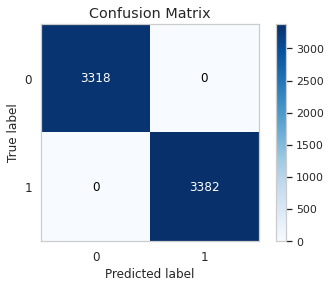

In [58]:
report(linear_svc_model_cv,count_vectorizer_train,Y_train['polarity'],'Linear SVM Model','Training',training_accuracy_scores,training_auc_scores)

Linear SVM Model Validation Data Result:
Accuracy Score: 74.58%
AUC Score: 74.57%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.744615     0.746866  0.745758     0.745741      0.745751
recall        0.740514     0.750900  0.745758     0.745707      0.745758
f1-score      0.742559     0.748878  0.745758     0.745718      0.745749
support    1634.000000  1666.000000  0.745758  3300.000000   3300.000000


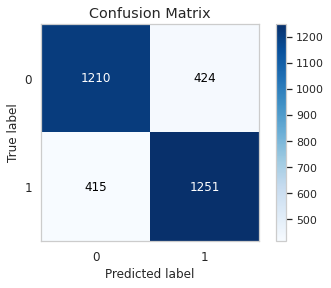

In [59]:
report(linear_svc_model_cv,count_vectorizer_val,Y_val['polarity'],'Linear SVM Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [60]:
# Descision Tree Classifier
#Finding Best Hyperparameter For Decision Tree [New Addition]
params = {
 'decisiontreeclassifier__max_depth': [10,15,20],
 'decisiontreeclassifier__min_samples_split': [2,4,6],
 'decisiontreeclassifier__min_samples_leaf':[100,200,300]
}
# Checking If Model Exist then load it.
decision_tree_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('decisiontreeclassifier', DecisionTreeClassifier())])
decision_tree_model_cv = GridSearchCV(decision_tree_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
decision_tree_model_cv.fit(count_vectorizer_train, Y_train['polarity'])
bestParams = decision_tree_model_cv.best_params_
print(f"Decision Tree Best paramters: {bestParams})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree Best paramters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 100, 'decisiontreeclassifier__min_samples_split': 2})


Decision Tree Model Training Data Result:
Accuracy Score: 69.96%
AUC Score: 69.97%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.688312     0.711592  0.699552     0.699952      0.700063
recall        0.718807     0.680662  0.699552     0.699734      0.699552
f1-score      0.703229     0.695784  0.699552     0.699506      0.699471
support    3318.000000  3382.000000  0.699552  6700.000000   6700.000000


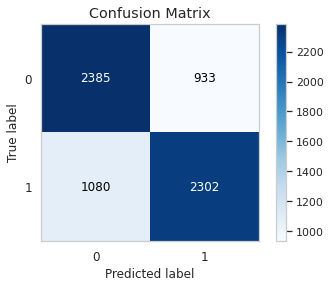

In [61]:
report(decision_tree_model_cv,count_vectorizer_train,Y_train['polarity'],'Decision Tree Model','Training',training_accuracy_scores,training_auc_scores)

Decision Tree Model Validation Data Result:
Accuracy Score: 69.85%
AUC Score: 69.88%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.681431     0.717999  0.698485     0.699715      0.699892
recall        0.734394     0.663265  0.698485     0.698830      0.698485
f1-score      0.706922     0.689548  0.698485     0.698235      0.698151
support    1634.000000  1666.000000  0.698485  3300.000000   3300.000000


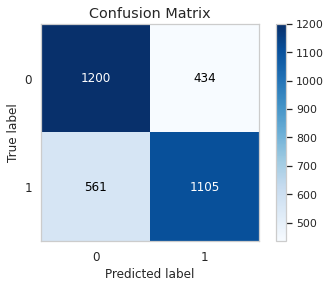

In [62]:
report(decision_tree_model_cv,count_vectorizer_val,Y_val['polarity'],'Decision Tree Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [63]:
#Finding Best Hyperparameter For Random Forest [New Addition]
params = {
 'randomforestclassifier__max_depth': [10,15,20],
 'randomforestclassifier__min_samples_split': [2,4,6],
 'randomforestclassifier__min_samples_leaf':[100,200,300]
}
rf_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=4,min_samples_leaf=300))])
rf_model_cv = GridSearchCV(rf_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
rf_model_cv.fit(count_vectorizer_train, Y_train['polarity'])
rf_best_params = rf_model_cv.best_params_
print(f"Random Forest Best paramters: {rf_best_params})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest Best paramters: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__min_samples_split': 4})


Random Forest Model Training Data Result:
Accuracy Score: 75.72%
AUC Score: 75.68%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.777668     0.740082  0.757164     0.758875      0.758696
recall        0.713683     0.799823  0.757164     0.756753      0.757164
f1-score      0.744303     0.768794  0.757164     0.756548      0.756665
support    3318.000000  3382.000000  0.757164  6700.000000   6700.000000


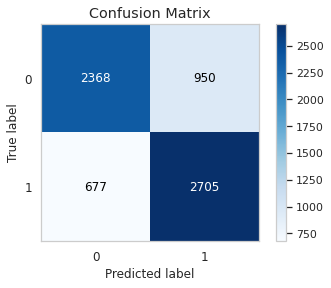

In [64]:
report(rf_model_cv,count_vectorizer_train,Y_train['polarity'],'Random Forest Model','Training',training_accuracy_scores,training_auc_scores)

Random Forest Model Validation Data Result:
Accuracy Score: 74.61%
AUC Score: 74.58%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.755456     0.737658  0.746061     0.746557      0.746470
recall        0.720318     0.771309  0.746061     0.745813      0.746061
f1-score      0.737469     0.754108  0.746061     0.745788      0.745869
support    1634.000000  1666.000000  0.746061  3300.000000   3300.000000


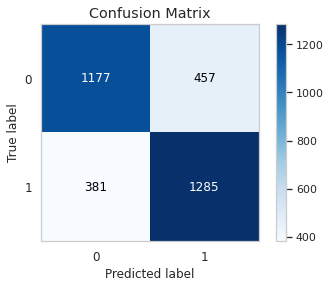

In [65]:
report(rf_model_cv,count_vectorizer_val,Y_val['polarity'],'Random Forest Model','Validation',validation_accuracy_scores,validation_auc_scores)

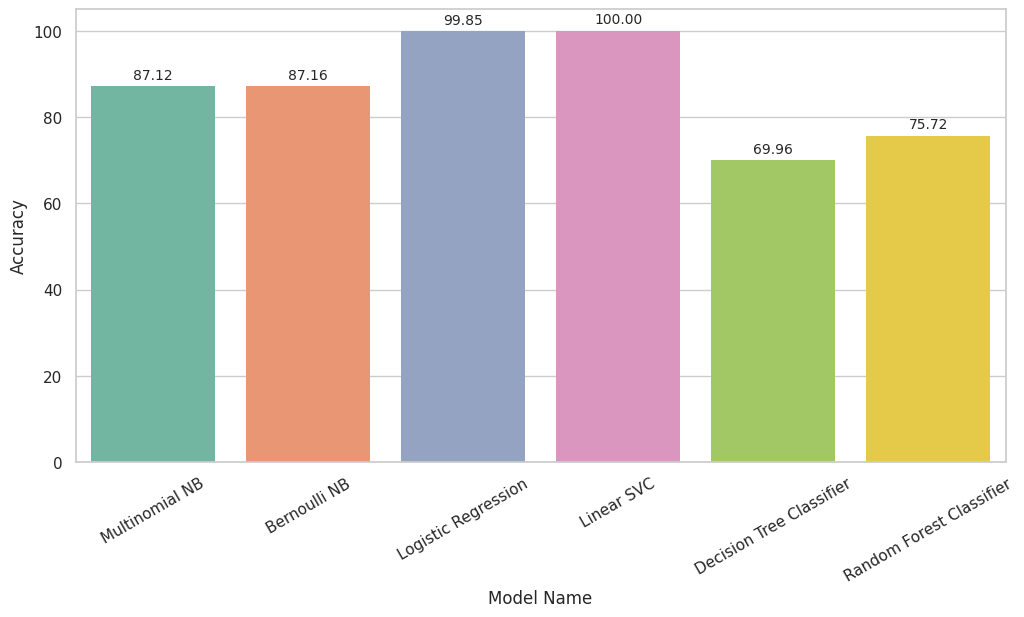

In [66]:
model_name_list = ['Multinomial NB','Bernoulli NB','Logistic Regression','Linear SVC','Decision Tree Classifier','Random Forest Classifier']
df_train = pd.DataFrame(model_name_list,columns=['model_name'])
df_train['accuracy_score'] = training_accuracy_scores
df_val = pd.DataFrame(model_name_list,columns=['model_name'])
df_val['accuracy_score'] = validation_accuracy_scores
create_barplot(df_train,'Model Name','Accuracy','model_name','accuracy_score','count_vectorizer_train_accuracy')

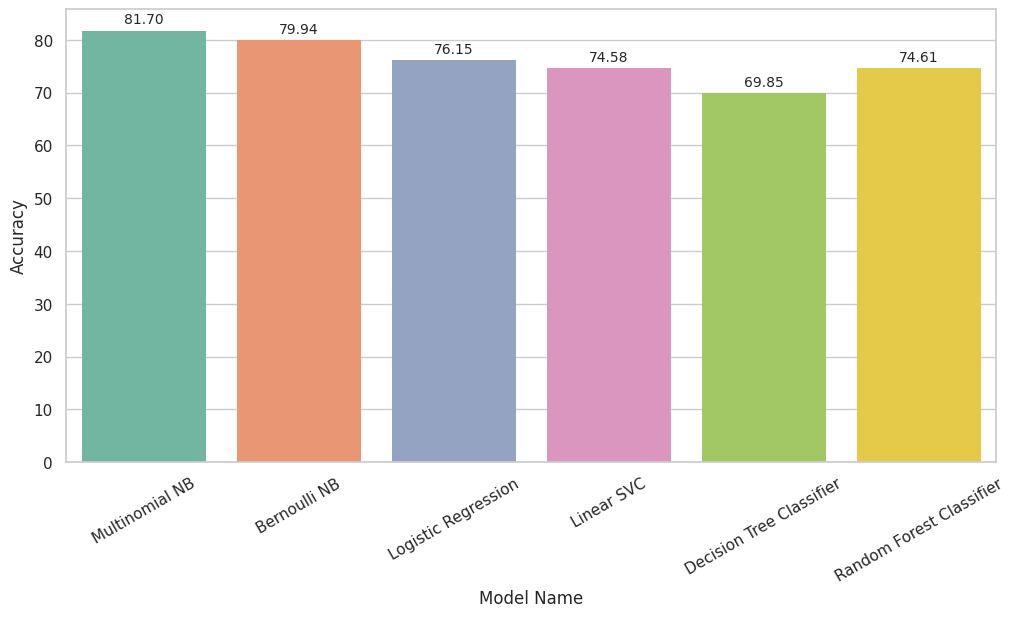

In [67]:
create_barplot(df_val,'Model Name','Accuracy','model_name','accuracy_score','count_vectorizer_val_accuracy')

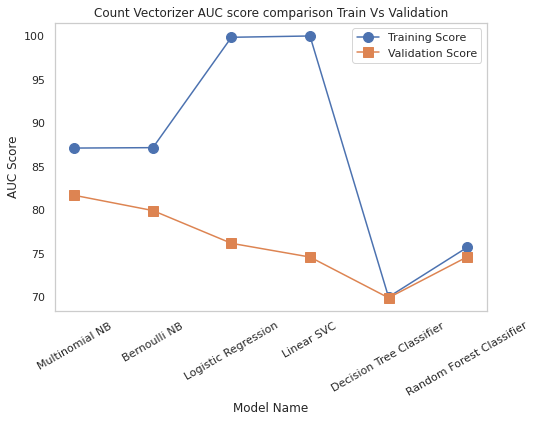

In [68]:
#Creating Canvas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_ylabel('AUC Score')
ax.set_xlabel('Model Name')
ax.set_title('Count Vectorizer AUC score comparison Train Vs Validation')

#Creating Multiline Plot
ax.plot(model_name_list,training_auc_scores, label="Training Score",marker='o',ms=10)
ax.plot(model_name_list,validation_auc_scores, label="Validation Score",marker='s',ms=10)

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
ax.tick_params(axis='x', rotation=30)
plt.show()
plt.close()

## Tf-Idf Vectorizer

In [69]:
# import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# initialize tfifd vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=0.001)
tfidf_vectorizer_train = tfidf_vectorizer.fit_transform(X_train['review'])
tfidf_vectorizer_val = tfidf_vectorizer.transform(X_val['review'])

Bernouli NB Model Training Data Result:
Accuracy Score: 87.12%
AUC Score: 87.11%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.878975     0.863912  0.871194     0.871444      0.871372
recall        0.858047     0.884092  0.871194     0.871070      0.871194
f1-score      0.868385     0.873886  0.871194     0.871135      0.871162
support    3318.000000  3382.000000  0.871194  6700.000000   6700.000000


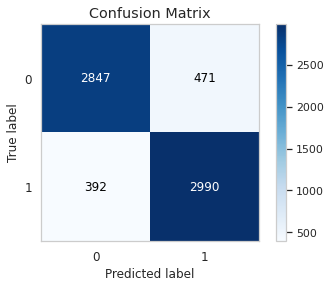

In [70]:
# Naive Bayes Classifier
naive_bayes_classifier = BernoulliNB()

#create the naive bayes model for the train data
naive_bayes_classifier.fit(tfidf_vectorizer_train, Y_train['polarity'])
# initializing scores list
training_accuracy_scores = []
training_auc_scores = []
report(naive_bayes_classifier,tfidf_vectorizer_train,Y_train['polarity'],'Bernouli NB Model','Training',training_accuracy_scores,training_auc_scores)

Bernouli NB Model Validation Data Result:
Accuracy Score: 81.70%
AUC Score: 81.67%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.831403     0.804124   0.81697     0.817763      0.817631
recall        0.790698     0.842737   0.81697     0.816717      0.816970
f1-score      0.810540     0.822978   0.81697     0.816759      0.816819
support    1634.000000  1666.000000   0.81697  3300.000000   3300.000000


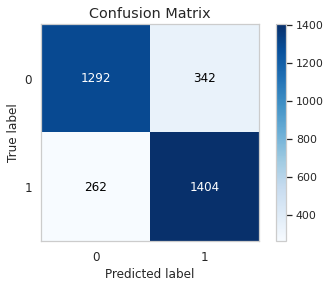

In [71]:
##create the naive bayes model for the validation data
# initializing scores list
validation_accuracy_scores = []
validation_auc_scores = []
report(naive_bayes_classifier,tfidf_vectorizer_val,Y_val['polarity'],'Bernouli NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

Multinomial NB Model Training Data Result:
Accuracy Score: 87.46%
AUC Score: 87.45%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.882644     0.867129  0.874627     0.874886      0.874812
recall        0.861362     0.887640  0.874627     0.874501      0.874627
f1-score      0.871873     0.877265  0.874627     0.874569      0.874595
support    3318.000000  3382.000000  0.874627  6700.000000   6700.000000


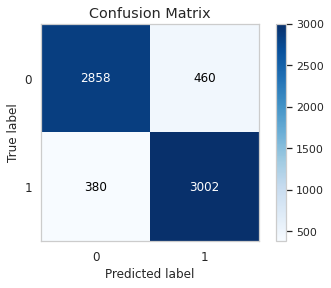

In [72]:
# Multinomial Naive Bayes Classifier
multi_naive_bayes_classifier = MultinomialNB()

#create the naive bayes model for the train data
multi_naive_bayes_classifier.fit(tfidf_vectorizer_train, Y_train['polarity'])
report(multi_naive_bayes_classifier,tfidf_vectorizer_train,Y_train['polarity'],'Multinomial NB Model','Training',training_accuracy_scores,training_auc_scores)

Multinomial NB Model Validation Data Result:
Accuracy Score: 79.82%
AUC Score: 79.79%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.811054     0.786697  0.798182     0.798876      0.798758
recall        0.772338     0.823529  0.798182     0.797934      0.798182
f1-score      0.791223     0.804692  0.798182     0.797957      0.798023
support    1634.000000  1666.000000  0.798182  3300.000000   3300.000000


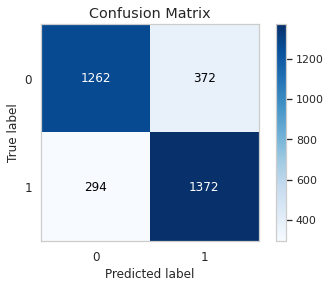

In [73]:
# Multinomial Validation Model
# initializing scores list
report(multi_naive_bayes_classifier,tfidf_vectorizer_val,Y_val['polarity'],'Multinomial NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [74]:
# Logistic Regression Training Model
params = {
              'logisticregression__C': [0.1, 1, 10],
              }
log_reg_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('logisticregression', LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))])
log_reg_model_cv = GridSearchCV(log_reg_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
log_reg_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
bestParams = log_reg_model_cv.best_params_
print(f"Logistic Regression Model Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression Model Best paramters: {'logisticregression__C': 0.1})


Logistic Regression Model Training Data Result:
Accuracy Score: 85.48%
AUC Score: 85.60%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.778173     0.984708  0.854776     0.881441      0.882427
recall        0.988547     0.723536  0.854776     0.856042      0.854776
f1-score      0.870835     0.834157  0.854776     0.852496      0.852321
support    3318.000000  3382.000000  0.854776  6700.000000   6700.000000


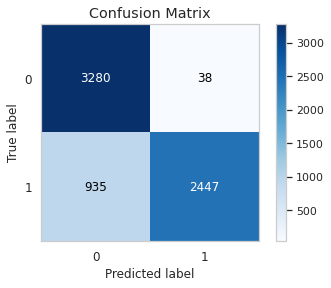

In [75]:
report(log_reg_model_cv,tfidf_vectorizer_train,Y_train['polarity'],'Logistic Regression Model','Training',training_accuracy_scores,training_auc_scores)

Logistic Regression Model Validation Data Result:
Accuracy Score: 70.30%
AUC Score: 70.44%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.654391     0.790186   0.70303     0.722289      0.722947
recall        0.848225     0.560624   0.70303     0.704425      0.703030
f1-score      0.738806     0.655899   0.70303     0.697352      0.696950
support    1634.000000  1666.000000   0.70303  3300.000000   3300.000000


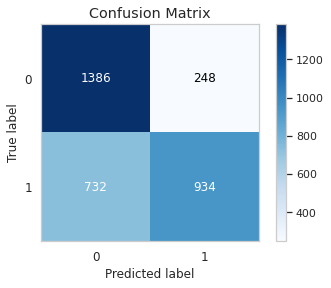

In [76]:
report(log_reg_model_cv,tfidf_vectorizer_val,Y_val['polarity'],'Logistic Regression Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [77]:
# SVM Training Model
#Hyperparameter Tuning [New Addition]
params = {
              'linearsvm__C': [0.1, 1, 10],
              }
linear_svc_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('linearsvm', LinearSVC(tol=1e-5))])
linear_svc_model_cv = GridSearchCV(linear_svc_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
linear_svc_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
bestParams = linear_svc_model_cv.best_params_
print(f"Linear SVM Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Linear SVM Best paramters: {'linearsvm__C': 0.1})


Linear SVM Model Training Data Result:
Accuracy Score: 86.46%
AUC Score: 86.56%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.799057     0.963657  0.864627     0.881357      0.882143
recall        0.970766     0.760497  0.864627     0.865631      0.864627
f1-score      0.876582     0.850107  0.864627     0.863345      0.863218
support    3318.000000  3382.000000  0.864627  6700.000000   6700.000000


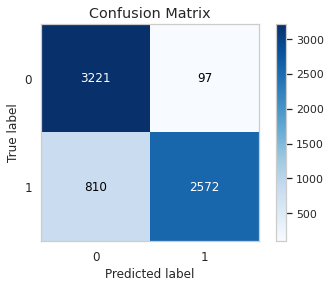

In [78]:
report(linear_svc_model_cv,tfidf_vectorizer_train,Y_train['polarity'],'Linear SVM Model','Training',training_accuracy_scores,training_auc_scores)

Linear SVM Model Validation Data Result:
Accuracy Score: 69.03%
AUC Score: 69.12%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.657732     0.736765  0.690303     0.697248      0.697632
recall        0.780906     0.601441  0.690303     0.691173      0.690303
f1-score      0.714046     0.662260  0.690303     0.688153      0.687902
support    1634.000000  1666.000000  0.690303  3300.000000   3300.000000


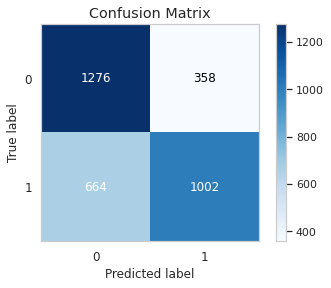

In [79]:
report(linear_svc_model_cv,tfidf_vectorizer_val,Y_val['polarity'],'Linear SVM Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [80]:
# Descision Tree Classifier
#Finding Best Hyperparameter For Decision Tree [New Addition]
params = {
 'decisiontreeclassifier__max_depth': [10,15,20],
 'decisiontreeclassifier__min_samples_split': [2,4,6],
 'decisiontreeclassifier__min_samples_leaf':[100,200,300]
}
# Checking If Model Exist then load it.
decision_tree_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('decisiontreeclassifier', DecisionTreeClassifier())])
decision_tree_model_cv = GridSearchCV(decision_tree_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
decision_tree_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
bestParams = decision_tree_model_cv.best_params_
print(f"Decision Tree Best paramters: {bestParams})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree Best paramters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 100, 'decisiontreeclassifier__min_samples_split': 2})


Decision Tree Model Training Data Result:
Accuracy Score: 49.69%
AUC Score: 50.16%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.496038     1.000000  0.496866     0.748019      0.750426
recall        1.000000     0.003253  0.496866     0.501626      0.496866
f1-score      0.663136     0.006484  0.496866     0.334810      0.331674
support    3318.000000  3382.000000  0.496866  6700.000000   6700.000000


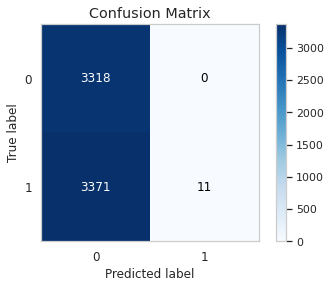

In [81]:
report(decision_tree_model_cv,tfidf_vectorizer_train,Y_train['polarity'],'Decision Tree Model','Training',training_accuracy_scores,training_auc_scores)

Decision Tree Model Validation Data Result:
Accuracy Score: 49.79%
AUC Score: 50.27%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.496506     1.000000  0.497879     0.748253      0.750694
recall        1.000000     0.005402  0.497879     0.502701      0.497879
f1-score      0.663553     0.010746  0.497879     0.337150      0.333985
support    1634.000000  1666.000000  0.497879  3300.000000   3300.000000


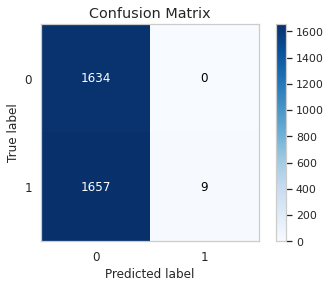

In [82]:
report(decision_tree_model_cv,tfidf_vectorizer_val,Y_val['polarity'],'Decision Tree Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [83]:
#Finding Best Hyperparameter For Random Forest [New Addition]
params = {
 'randomforestclassifier__max_depth': [10,15,20],
 'randomforestclassifier__min_samples_split': [2,4,6],
 'randomforestclassifier__min_samples_leaf':[100,200,300]
}
rf_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=4,min_samples_leaf=300))])
rf_model_cv = GridSearchCV(rf_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
rf_model_cv.fit(count_vectorizer_ohe_train, Y_train['polarity'])
rf_best_params = rf_model_cv.best_params_
print(f"Random Forest Best paramters: {rf_best_params})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest Best paramters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__min_samples_split': 6})


Random Forest Model Training Data Result:
Accuracy Score: 50.12%
AUC Score: 50.59%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.498188     0.756410  0.501194     0.627299      0.628532
recall        0.994274     0.017445  0.501194     0.505859      0.501194
f1-score      0.663783     0.034104  0.501194     0.348943      0.345936
support    3318.000000  3382.000000  0.501194  6700.000000   6700.000000


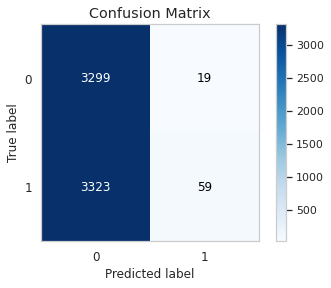

In [84]:
report(rf_model_cv,tfidf_vectorizer_train,Y_train['polarity'],'Random Forest Model','Training',training_accuracy_scores,training_auc_scores)

Random Forest Model Validation Data Result:
Accuracy Score: 50.06%
AUC Score: 50.53%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.497854     0.736842  0.500606     0.617348      0.618507
recall        0.993880     0.016807  0.500606     0.505343      0.500606
f1-score      0.663399     0.032864  0.500606     0.348131      0.345074
support    1634.000000  1666.000000  0.500606  3300.000000   3300.000000


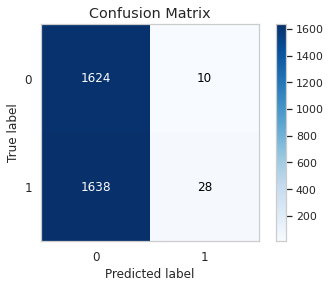

In [85]:
report(rf_model_cv,tfidf_vectorizer_val,Y_val['polarity'],'Random Forest Model','Validation',validation_accuracy_scores,validation_auc_scores)

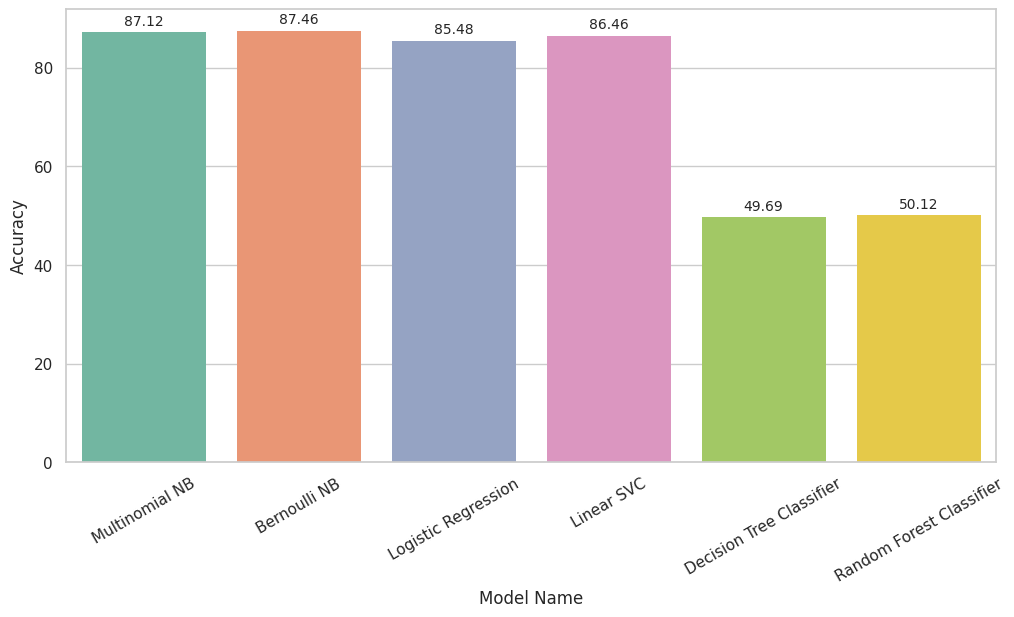

In [88]:
model_name_list = ['Multinomial NB','Bernoulli NB','Logistic Regression','Linear SVC','Decision Tree Classifier','Random Forest Classifier']
df_train = pd.DataFrame(model_name_list,columns=['model_name'])
df_train['accuracy_score'] = training_accuracy_scores
df_val = pd.DataFrame(model_name_list,columns=['model_name'])
df_val['accuracy_score'] = validation_accuracy_scores
create_barplot(df_train,'Model Name','Accuracy','model_name','accuracy_score','tfidf_train_accuracy')

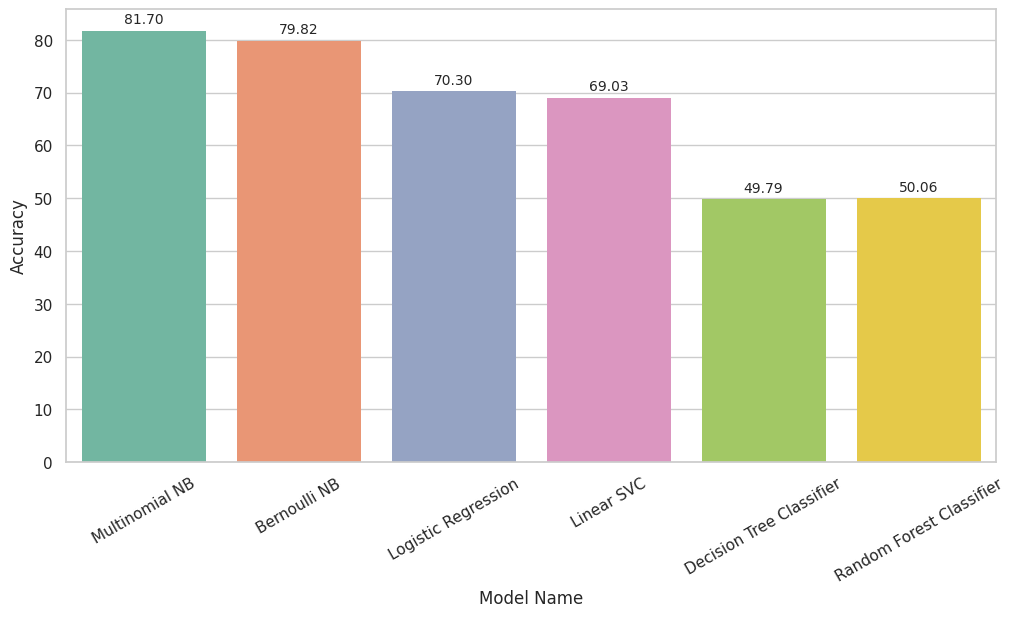

In [89]:
create_barplot(df_val,'Model Name','Accuracy','model_name','accuracy_score','tfidf_val_accuracy')

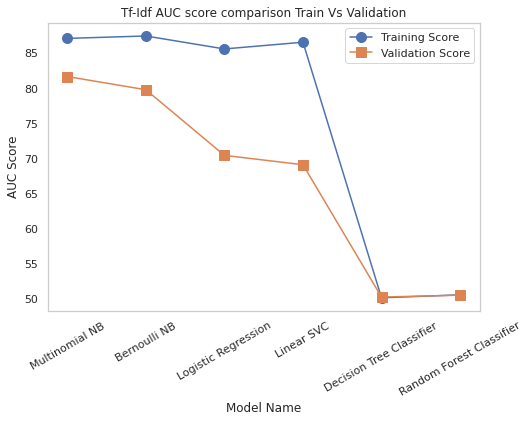

In [90]:
#Creating Canvas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_ylabel('AUC Score')
ax.set_xlabel('Model Name')
ax.set_title('Tf-Idf AUC score comparison Train Vs Validation')

#Creating Multiline Plot
ax.plot(model_name_list,training_auc_scores, label="Training Score",marker='o',ms=10)
ax.plot(model_name_list,validation_auc_scores, label="Validation Score",marker='s',ms=10)

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
ax.tick_params(axis='x', rotation=30)
plt.show()
plt.close()

### Tf-Idf N-gram Vectorizer

In [92]:
tfidf_ngram_vectorizer = TfidfVectorizer(min_df=0.001, ngram_range=(1, 3))
#create the naive bayes model for the train data using tfidf and ngram
tfidf_ngram_vectorizer_train = tfidf_ngram_vectorizer.fit_transform(X_train['review'])
tfidf_ngram_vectorizer_val = tfidf_ngram_vectorizer.transform(X_val['review'])

In [93]:
tfidf_ngram_vectorizer.get_feature_names_out()[150:160]

array(['annoying', 'answer', 'answer question', 'antenna', 'anthem',
       'anthology', 'anticipate', 'anticipation', 'anybody', 'anymore'],
      dtype=object)

Bernouli NB Model Training Data Result:
Accuracy Score: 88.57%
AUC Score: 88.55%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.894314     0.877598  0.885672     0.885956      0.885876
recall        0.872212     0.898876  0.885672     0.885544      0.885672
f1-score      0.883125     0.888110  0.885672     0.885617      0.885641
support    3318.000000  3382.000000  0.885672  6700.000000   6700.000000


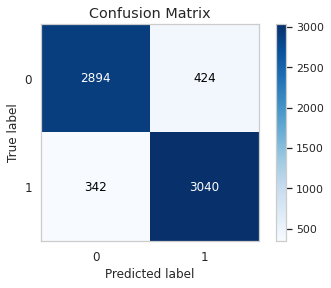

In [96]:
# Naive Bayes Classifier
naive_bayes_classifier = BernoulliNB()
 
#create the naive bayes model for the train data
naive_bayes_classifier.fit(tfidf_ngram_vectorizer_train, Y_train['polarity'])
# initializing scores list
training_accuracy_scores = []
training_auc_scores = []
report(naive_bayes_classifier,tfidf_ngram_vectorizer_train,Y_train['polarity'],'Bernouli NB Model','Training',training_accuracy_scores,training_auc_scores)

Bernouli NB Model Validation Data Result:
Accuracy Score: 82.58%
AUC Score: 82.55%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.840077     0.812966  0.825758     0.826522      0.826390
recall        0.800490     0.850540  0.825758     0.825515      0.825758
f1-score      0.819806     0.831329  0.825758     0.825567      0.825623
support    1634.000000  1666.000000  0.825758  3300.000000   3300.000000


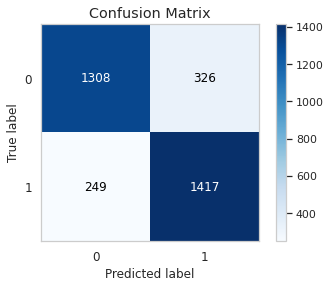

In [97]:
# initializing scores list
validation_accuracy_scores = []
validation_auc_scores = []
report(naive_bayes_classifier,tfidf_ngram_vectorizer_val,Y_val['polarity'],'Bernouli NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

Multinomial NB Model Training Data Result:
Accuracy Score: 88.87%
AUC Score: 88.85%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.895692     0.882029  0.888657     0.888861      0.888795
recall        0.877336     0.899763  0.888657     0.888550      0.888657
f1-score      0.886419     0.890808  0.888657     0.888613      0.888634
support    3318.000000  3382.000000  0.888657  6700.000000   6700.000000


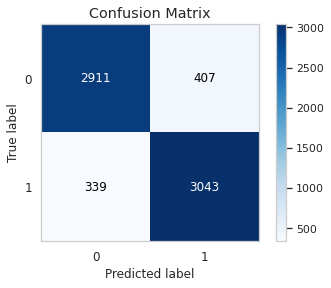

In [98]:
# Multinomial Naive Bayes Classifier
multi_naive_bayes_classifier = MultinomialNB()

#create the naive bayes model for the train data
multi_naive_bayes_classifier.fit(tfidf_ngram_vectorizer_train, Y_train['polarity'])
report(multi_naive_bayes_classifier,tfidf_ngram_vectorizer_train,Y_train['polarity'],'Multinomial NB Model','Training',training_accuracy_scores,training_auc_scores)

Multinomial NB Model Validation Data Result:
Accuracy Score: 81.39%
AUC Score: 81.37%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.828185     0.801260  0.813939     0.814723      0.814592
recall        0.787638     0.839736  0.813939     0.813687      0.813939
f1-score      0.807403     0.820047  0.813939     0.813725      0.813786
support    1634.000000  1666.000000  0.813939  3300.000000   3300.000000


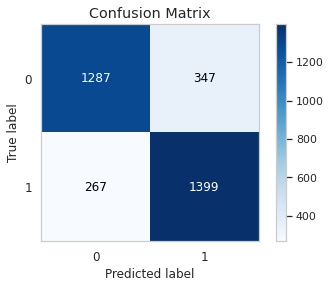

In [99]:
# Multinomial Validation Model
# initializing scores list
report(multi_naive_bayes_classifier,tfidf_ngram_vectorizer_val,Y_val['polarity'],'Multinomial NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [100]:
# Logistic Regression Training Model
params = {
              'logisticregression__C': [0.1, 1, 10],
              }
log_reg_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('logisticregression', LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))])
log_reg_model_cv = GridSearchCV(log_reg_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
log_reg_model_cv.fit(tfidf_ngram_vectorizer_train, Y_train['polarity'])
bestParams = log_reg_model_cv.best_params_
print(f"Logistic Regression Model Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression Model Best paramters: {'logisticregression__C': 0.1})


Logistic Regression Model Training Data Result:
Accuracy Score: 100.00%
AUC Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    3318.0  3382.0       1.0     6700.0        6700.0


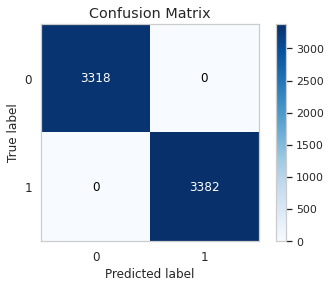

In [101]:
report(log_reg_model_cv,tfidf_ngram_vectorizer_train,Y_train['polarity'],'Logistic Regression Model','Training',training_accuracy_scores,training_auc_scores)

Logistic Regression Model Validation Data Result:
Accuracy Score: 77.94%
AUC Score: 77.93%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.779285     0.779499  0.779394     0.779392      0.779393
recall        0.773562     0.785114  0.779394     0.779338      0.779394
f1-score      0.776413     0.782297  0.779394     0.779355      0.779383
support    1634.000000  1666.000000  0.779394  3300.000000   3300.000000


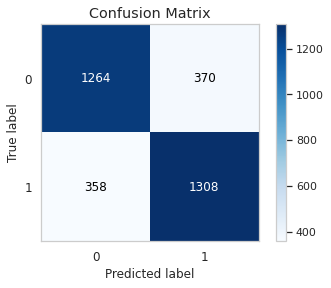

In [102]:
report(log_reg_model_cv,tfidf_ngram_vectorizer_val,Y_val['polarity'],'Logistic Regression Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [103]:
# SVM Training Model
#Hyperparameter Tuning [New Addition]
params = {
              'linearsvm__C': [0.1, 1, 10],
              }
linear_svc_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('linearsvm', LinearSVC(tol=1e-5))])
linear_svc_model_cv = GridSearchCV(linear_svc_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
linear_svc_model_cv.fit(tfidf_ngram_vectorizer_train, Y_train['polarity'])
bestParams = linear_svc_model_cv.best_params_
print(f"Linear SVM Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Linear SVM Best paramters: {'linearsvm__C': 1})


Linear SVM Model Training Data Result:
Accuracy Score: 100.00%
AUC Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    3318.0  3382.0       1.0     6700.0        6700.0


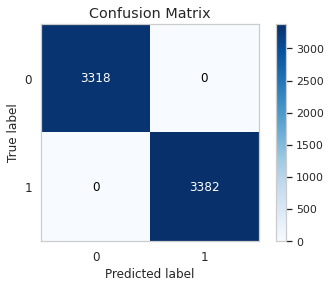

In [104]:
report(linear_svc_model_cv,tfidf_ngram_vectorizer_train,Y_train['polarity'],'Linear SVM Model','Training',training_accuracy_scores,training_auc_scores)

Linear SVM Model Validation Data Result:
Accuracy Score: 74.91%
AUC Score: 74.91%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.746032     0.752106  0.749091     0.749069      0.749098
recall        0.747858     0.750300  0.749091     0.749079      0.749091
f1-score      0.746944     0.751202  0.749091     0.749073      0.749093
support    1634.000000  1666.000000  0.749091  3300.000000   3300.000000


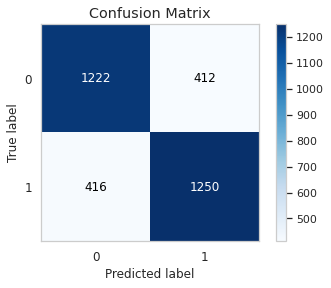

In [105]:
report(linear_svc_model_cv,tfidf_ngram_vectorizer_val,Y_val['polarity'],'Linear SVM Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [106]:
# Descision Tree Classifier
#Finding Best Hyperparameter For Decision Tree [New Addition]
params = {
 'decisiontreeclassifier__max_depth': [10,15,20],
 'decisiontreeclassifier__min_samples_split': [2,4,6],
 'decisiontreeclassifier__min_samples_leaf':[100,200,300]
}
# Checking If Model Exist then load it.
decision_tree_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('decisiontreeclassifier', DecisionTreeClassifier())])
decision_tree_model_cv = GridSearchCV(decision_tree_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
decision_tree_model_cv.fit(tfidf_ngram_vectorizer_train, Y_train['polarity'])
bestParams = decision_tree_model_cv.best_params_
print(f"Decision Tree Best paramters: {bestParams})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree Best paramters: {'decisiontreeclassifier__max_depth': 15, 'decisiontreeclassifier__min_samples_leaf': 100, 'decisiontreeclassifier__min_samples_split': 2})


Decision Tree Model Training Data Result:
Accuracy Score: 71.22%
AUC Score: 71.19%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.723616     0.702394  0.712239     0.713005      0.712904
recall        0.677818     0.746008  0.712239     0.711913      0.712239
f1-score      0.699969     0.723545  0.712239     0.711757      0.711869
support    3318.000000  3382.000000  0.712239  6700.000000   6700.000000


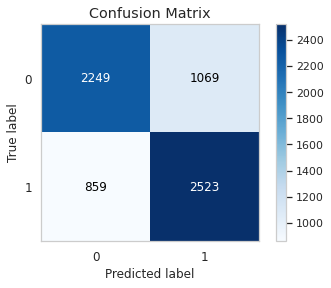

In [107]:
report(decision_tree_model_cv,tfidf_ngram_vectorizer_train,Y_train['polarity'],'Decision Tree Model','Training',training_accuracy_scores,training_auc_scores)

Decision Tree Model Validation Data Result:
Accuracy Score: 68.97%
AUC Score: 68.94%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.697539     0.682802  0.689697     0.690170      0.690099
recall        0.659119     0.719688  0.689697     0.689403      0.689697
f1-score      0.677785     0.700760  0.689697     0.689272      0.689384
support    1634.000000  1666.000000  0.689697  3300.000000   3300.000000


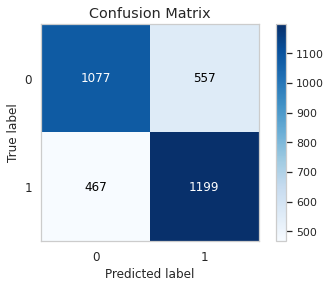

In [108]:
report(decision_tree_model_cv,tfidf_ngram_vectorizer_val,Y_val['polarity'],'Decision Tree Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [109]:
#Finding Best Hyperparameter For Random Forest [New Addition]
params = {
 'randomforestclassifier__max_depth': [10,15,20],
 'randomforestclassifier__min_samples_split': [2,4,6],
 'randomforestclassifier__min_samples_leaf':[100,200,300]
}
rf_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=4,min_samples_leaf=300))])
rf_model_cv = GridSearchCV(rf_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
rf_model_cv.fit(tfidf_ngram_vectorizer_train, Y_train['polarity'])
rf_best_params = rf_model_cv.best_params_
print(f"Random Forest Best paramters: {rf_best_params})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest Best paramters: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__min_samples_split': 2})


Random Forest Model Training Data Result:
Accuracy Score: 76.70%
AUC Score: 76.69%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.772911     0.761563  0.767015     0.767237      0.767183
recall        0.749849     0.783856  0.767015     0.766853      0.767015
f1-score      0.761205     0.772548  0.767015     0.766877      0.766931
support    3318.000000  3382.000000  0.767015  6700.000000   6700.000000


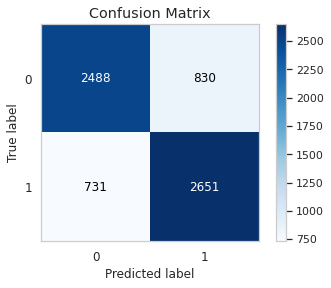

In [110]:
report(rf_model_cv,tfidf_ngram_vectorizer_train,Y_train['polarity'],'Random Forest Model','Training',training_accuracy_scores,training_auc_scores)

Random Forest Model Validation Data Result:
Accuracy Score: 74.15%
AUC Score: 74.14%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.741796     0.741246  0.741515     0.741521      0.741518
recall        0.733170     0.749700  0.741515     0.741435      0.741515
f1-score      0.737458     0.745449  0.741515     0.741453      0.741492
support    1634.000000  1666.000000  0.741515  3300.000000   3300.000000


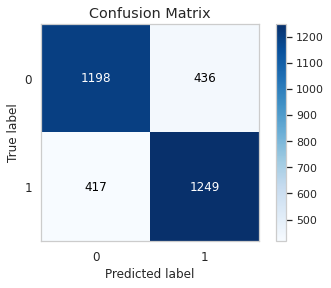

In [111]:
report(rf_model_cv,tfidf_ngram_vectorizer_val,Y_val['polarity'],'Random Forest Model','Validation',validation_accuracy_scores,validation_auc_scores)

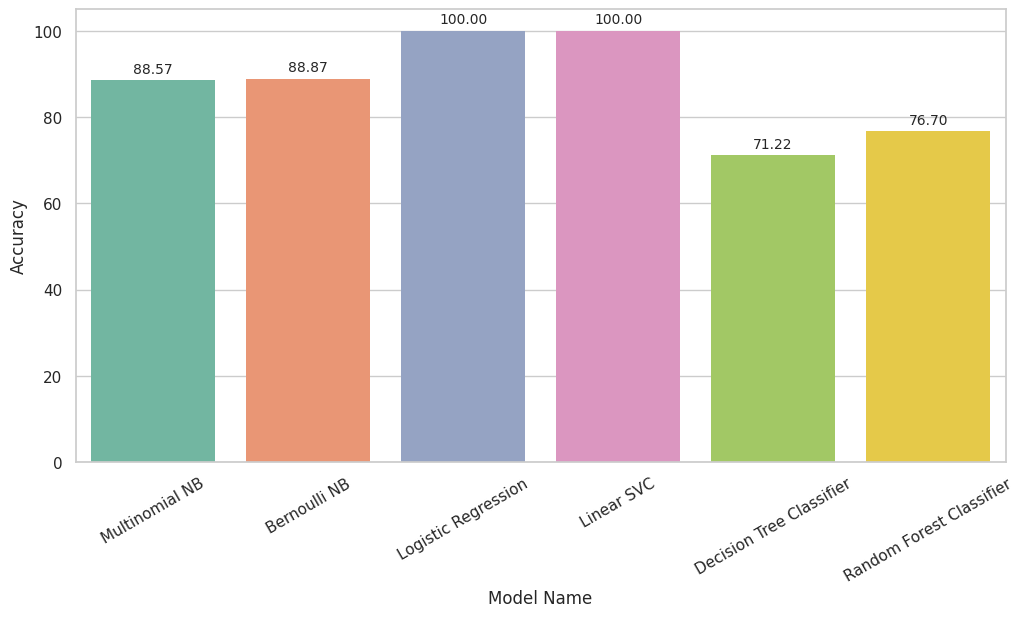

In [112]:
model_name_list = ['Multinomial NB','Bernoulli NB','Logistic Regression','Linear SVC','Decision Tree Classifier','Random Forest Classifier']
df_train = pd.DataFrame(model_name_list,columns=['model_name'])
df_train['accuracy_score'] = training_accuracy_scores
df_val = pd.DataFrame(model_name_list,columns=['model_name'])
df_val['accuracy_score'] = validation_accuracy_scores
create_barplot(df_train,'Model Name','Accuracy','model_name','accuracy_score','tfidf_ngram_train_accuracy')

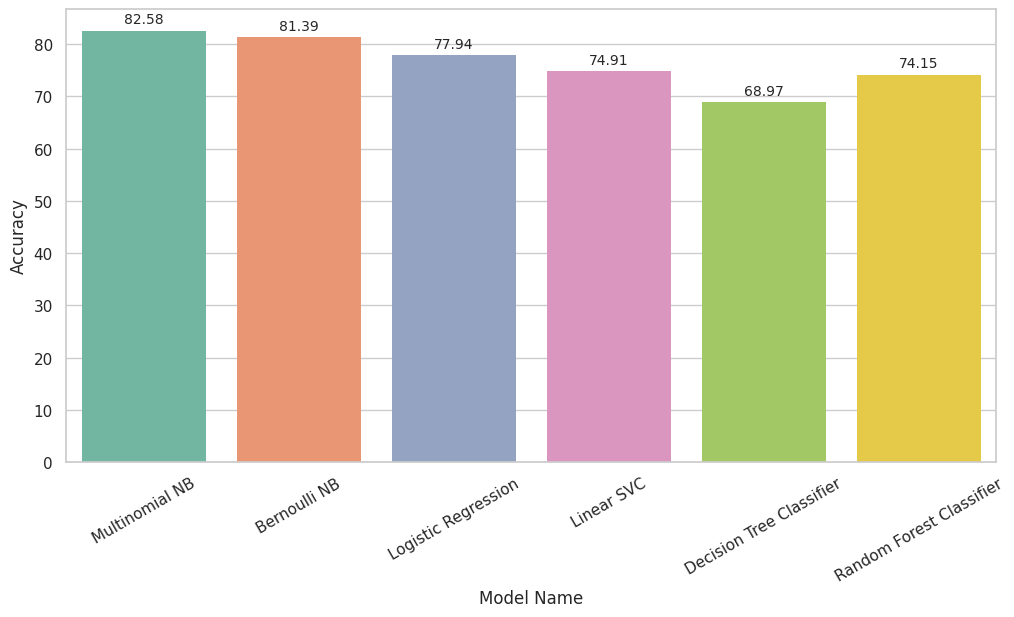

In [113]:
create_barplot(df_val,'Model Name','Accuracy','model_name','accuracy_score','tfidf_ngram_val_accuracy')

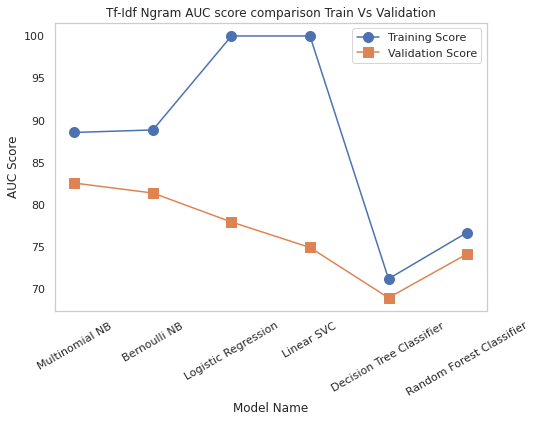

In [114]:
#Creating Canvas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_ylabel('AUC Score')
ax.set_xlabel('Model Name')
ax.set_title('Tf-Idf Ngram AUC score comparison Train Vs Validation')

#Creating Multiline Plot
ax.plot(model_name_list,training_auc_scores, label="Training Score",marker='o',ms=10)
ax.plot(model_name_list,validation_auc_scores, label="Validation Score",marker='s',ms=10)

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
ax.tick_params(axis='x', rotation=30)
plt.show()
plt.close()

### Count N-gram Vectorizer 

In [115]:
count_ngram_vectorizer = CountVectorizer(min_df=0.001, ngram_range=(1, 3))
#create the naive bayes model for the train data using count vectorizer and ngram
count_ngram_vectorizer_train = count_ngram_vectorizer.fit_transform(X_train['review'])
count_ngram_vectorizer_val = count_ngram_vectorizer.transform(X_val['review'])

Bernouli NB Model Training Data Result:
Accuracy Score: 88.57%
AUC Score: 88.55%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.894314     0.877598  0.885672     0.885956      0.885876
recall        0.872212     0.898876  0.885672     0.885544      0.885672
f1-score      0.883125     0.888110  0.885672     0.885617      0.885641
support    3318.000000  3382.000000  0.885672  6700.000000   6700.000000


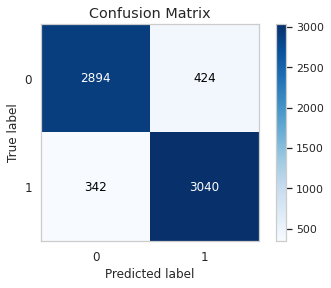

In [116]:
# Naive Bayes Classifier
naive_bayes_classifier = BernoulliNB()

#create the naive bayes model for the train data
naive_bayes_classifier.fit(count_ngram_vectorizer_train, Y_train['polarity'])
# initializing scores list
training_accuracy_scores = []
training_auc_scores = []
report(naive_bayes_classifier,count_ngram_vectorizer_train,Y_train['polarity'],'Bernouli NB Model','Training',training_accuracy_scores,training_auc_scores)

Bernouli NB Model Validation Data Result:
Accuracy Score: 82.58%
AUC Score: 82.55%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.840077     0.812966  0.825758     0.826522      0.826390
recall        0.800490     0.850540  0.825758     0.825515      0.825758
f1-score      0.819806     0.831329  0.825758     0.825567      0.825623
support    1634.000000  1666.000000  0.825758  3300.000000   3300.000000


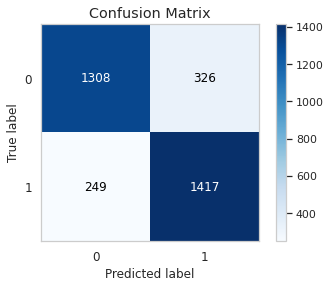

In [117]:
##create the naive bayes model for the validation data
# initializing scores list
validation_accuracy_scores = []
validation_auc_scores = []
report(naive_bayes_classifier,count_ngram_vectorizer_val,Y_val['polarity'],'Bernouli NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

Multinomial NB Model Training Data Result:
Accuracy Score: 88.21%
AUC Score: 88.20%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.890123     0.874566   0.88209     0.882345      0.882271
recall        0.869198     0.894737   0.88209     0.881968      0.882090
f1-score      0.879536     0.884537   0.88209     0.882037      0.882060
support    3318.000000  3382.000000   0.88209  6700.000000   6700.000000


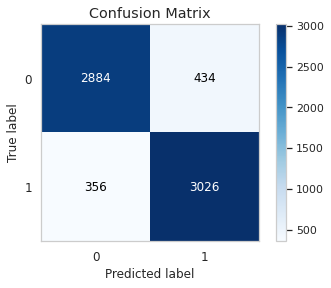

In [118]:
# Multinomial Naive Bayes Classifier
multi_naive_bayes_classifier = MultinomialNB()

#create the naive bayes model for the train data
multi_naive_bayes_classifier.fit(count_ngram_vectorizer_train, Y_train['polarity'])
report(multi_naive_bayes_classifier,count_ngram_vectorizer_train,Y_train['polarity'],'Multinomial NB Model','Training',training_accuracy_scores,training_auc_scores)

Multinomial NB Model Validation Data Result:
Accuracy Score: 81.18%
AUC Score: 81.16%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.824056     0.800806  0.811818     0.812431      0.812318
recall        0.788250     0.834934  0.811818     0.811592      0.811818
f1-score      0.805755     0.817514  0.811818     0.811635      0.811692
support    1634.000000  1666.000000  0.811818  3300.000000   3300.000000


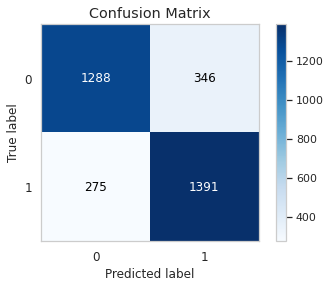

In [119]:
# Multinomial Validation Model
# initializing scores list
report(multi_naive_bayes_classifier,count_ngram_vectorizer_val,Y_val['polarity'],'Multinomial NB Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [120]:
# Logistic Regression Training Model
params = {
              'logisticregression__C': [0.1, 1, 10],
              }
log_reg_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('logisticregression', LogisticRegression(random_state=42,solver='lbfgs', max_iter=1000))])
log_reg_model_cv = GridSearchCV(log_reg_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
log_reg_model_cv.fit(count_ngram_vectorizer_train, Y_train['polarity'])
bestParams = log_reg_model_cv.best_params_
print(f"Logistic Regression Model Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Logistic Regression Model Best paramters: {'logisticregression__C': 0.1})


Logistic Regression Model Training Data Result:
Accuracy Score: 100.00%
AUC Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    3318.0  3382.0       1.0     6700.0        6700.0


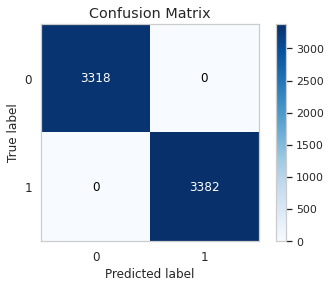

In [121]:
report(log_reg_model_cv,count_ngram_vectorizer_train,Y_train['polarity'],'Logistic Regression Model','Training',training_accuracy_scores,training_auc_scores)

Logistic Regression Model Validation Data Result:
Accuracy Score: 77.21%
AUC Score: 77.21%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.771218     0.772999  0.772121     0.772108      0.772117
recall        0.767442     0.776711  0.772121     0.772076      0.772121
f1-score      0.769325     0.774850  0.772121     0.772088      0.772115
support    1634.000000  1666.000000  0.772121  3300.000000   3300.000000


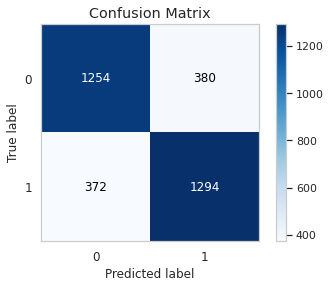

In [122]:
report(log_reg_model_cv,count_ngram_vectorizer_val,Y_val['polarity'],'Logistic Regression Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [123]:
# SVM Training Model
#Hyperparameter Tuning [New Addition]
params = {
              'linearsvm__C': [0.1, 1, 10],
              }
linear_svc_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('linearsvm', LinearSVC(tol=1e-5))])
linear_svc_model_cv = GridSearchCV(linear_svc_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
linear_svc_model_cv.fit(count_ngram_vectorizer_train, Y_train['polarity'])
bestParams = linear_svc_model_cv.best_params_
print(f"Linear SVM Best paramters: {bestParams})")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Linear SVM Best paramters: {'linearsvm__C': 0.1})


Linear SVM Model Training Data Result:
Accuracy Score: 100.00%
AUC Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                0       1  accuracy  macro avg  weighted avg
precision     1.0     1.0       1.0        1.0           1.0
recall        1.0     1.0       1.0        1.0           1.0
f1-score      1.0     1.0       1.0        1.0           1.0
support    3318.0  3382.0       1.0     6700.0        6700.0


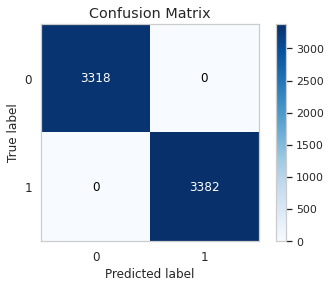

In [124]:
report(linear_svc_model_cv,count_ngram_vectorizer_train,Y_train['polarity'],'Linear SVM Model','Training',training_accuracy_scores,training_auc_scores)

Linear SVM Model Validation Data Result:
Accuracy Score: 75.21%
AUC Score: 75.21%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.749694     0.754502  0.752121     0.752098      0.752121
recall        0.749694     0.754502  0.752121     0.752098      0.752121
f1-score      0.749694     0.754502  0.752121     0.752098      0.752121
support    1634.000000  1666.000000  0.752121  3300.000000   3300.000000


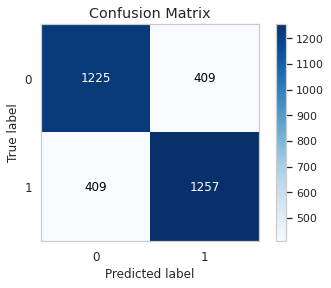

In [125]:
report(linear_svc_model_cv,count_ngram_vectorizer_val,Y_val['polarity'],'Linear SVM Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [126]:
# Descision Tree Classifier
#Finding Best Hyperparameter For Decision Tree [New Addition]
params = {
 'decisiontreeclassifier__max_depth': [10,15,20],
 'decisiontreeclassifier__min_samples_split': [2,4,6],
 'decisiontreeclassifier__min_samples_leaf':[100,200,300]
}
# Checking If Model Exist then load it.
decision_tree_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('decisiontreeclassifier', DecisionTreeClassifier())])
decision_tree_model_cv = GridSearchCV(decision_tree_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
decision_tree_model_cv.fit(count_ngram_vectorizer_train, Y_train['polarity'])
bestParams = decision_tree_model_cv.best_params_
print(f"Decision Tree Best paramters: {bestParams})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree Best paramters: {'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 100, 'decisiontreeclassifier__min_samples_split': 2})


Decision Tree Model Training Data Result:
Accuracy Score: 69.96%
AUC Score: 69.97%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.688312     0.711592  0.699552     0.699952      0.700063
recall        0.718807     0.680662  0.699552     0.699734      0.699552
f1-score      0.703229     0.695784  0.699552     0.699506      0.699471
support    3318.000000  3382.000000  0.699552  6700.000000   6700.000000


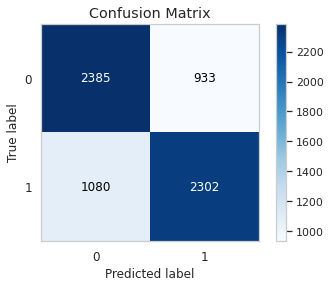

In [127]:
report(decision_tree_model_cv,count_ngram_vectorizer_train,Y_train['polarity'],'Decision Tree Model','Training',training_accuracy_scores,training_auc_scores)

Decision Tree Model Validation Data Result:
Accuracy Score: 69.85%
AUC Score: 69.88%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.681431     0.717999  0.698485     0.699715      0.699892
recall        0.734394     0.663265  0.698485     0.698830      0.698485
f1-score      0.706922     0.689548  0.698485     0.698235      0.698151
support    1634.000000  1666.000000  0.698485  3300.000000   3300.000000


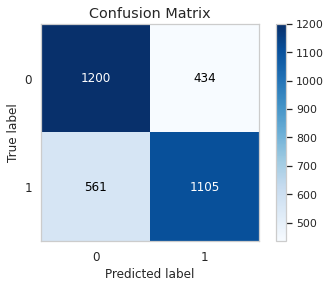

In [128]:
report(decision_tree_model_cv,count_ngram_vectorizer_val,Y_val['polarity'],'Decision Tree Model','Validation',validation_accuracy_scores,validation_auc_scores)

In [129]:
#Finding Best Hyperparameter For Random Forest [New Addition]
params = {
 'randomforestclassifier__max_depth': [10,15,20],
 'randomforestclassifier__min_samples_split': [2,4,6],
 'randomforestclassifier__min_samples_leaf':[100,200,300]
}
rf_model = Pipeline([('standardscaler', StandardScaler(with_mean=False)),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=4,min_samples_leaf=300))])
rf_model_cv = GridSearchCV(rf_model, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
rf_model_cv.fit(count_ngram_vectorizer_train, Y_train['polarity'])
rf_best_params = rf_model_cv.best_params_
print(f"Random Forest Best paramters: {rf_best_params})")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Random Forest Best paramters: {'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 100, 'randomforestclassifier__min_samples_split': 6})


Random Forest Model Training Data Result:
Accuracy Score: 75.36%
AUC Score: 75.31%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.779043     0.733100  0.753582     0.756071      0.755852
recall        0.701326     0.804849  0.753582     0.753088      0.753582
f1-score      0.738144     0.767301  0.753582     0.752723      0.752862
support    3318.000000  3382.000000  0.753582  6700.000000   6700.000000


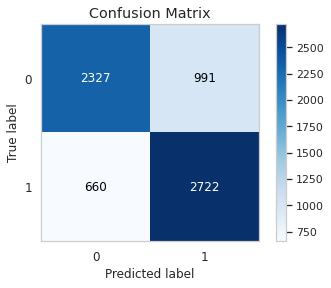

In [130]:
report(rf_model_cv,count_ngram_vectorizer_train,Y_train['polarity'],'Random Forest Model','Training',training_accuracy_scores,training_auc_scores)

Random Forest Model Validation Data Result:
Accuracy Score: 74.12%
AUC Score: 74.09%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.754569     0.729638  0.741212     0.742104      0.741983
recall        0.707466     0.774310  0.741212     0.740888      0.741212
f1-score      0.730259     0.751310  0.741212     0.740785      0.740887
support    1634.000000  1666.000000  0.741212  3300.000000   3300.000000


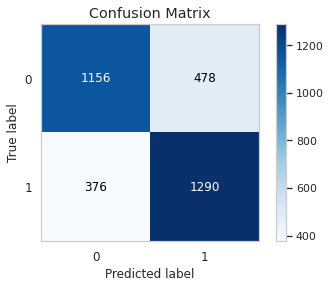

In [131]:
report(rf_model_cv,count_ngram_vectorizer_val,Y_val['polarity'],'Random Forest Model','Validation',validation_accuracy_scores,validation_auc_scores)

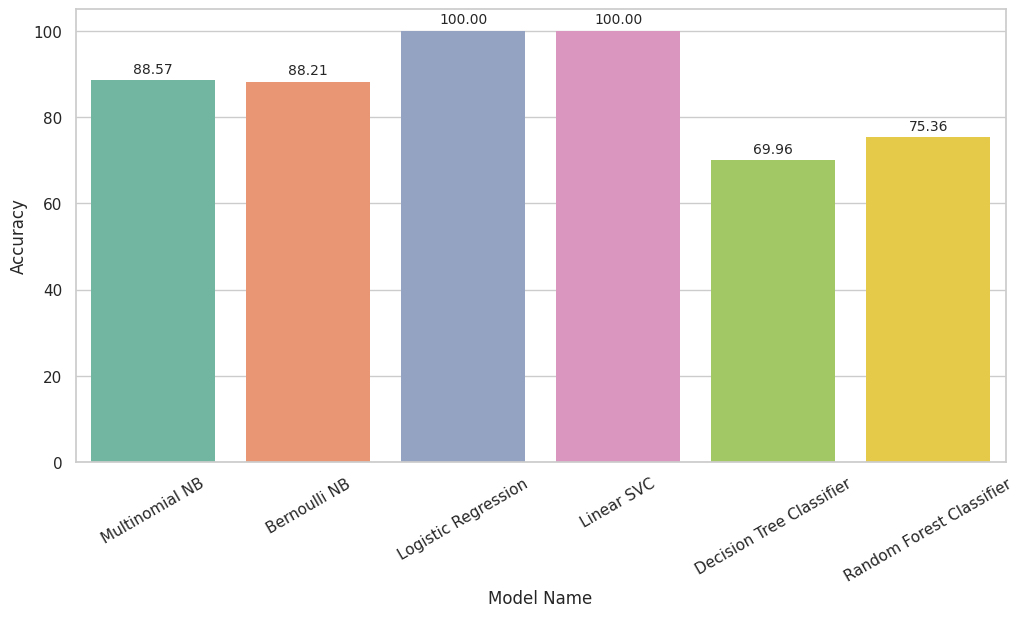

In [132]:
model_name_list = ['Multinomial NB','Bernoulli NB','Logistic Regression','Linear SVC','Decision Tree Classifier','Random Forest Classifier']
df_train = pd.DataFrame(model_name_list,columns=['model_name'])
df_train['accuracy_score'] = training_accuracy_scores
df_val = pd.DataFrame(model_name_list,columns=['model_name'])
df_val['accuracy_score'] = validation_accuracy_scores
create_barplot(df_train,'Model Name','Accuracy','model_name','accuracy_score','count_ngram_train_accuracy')

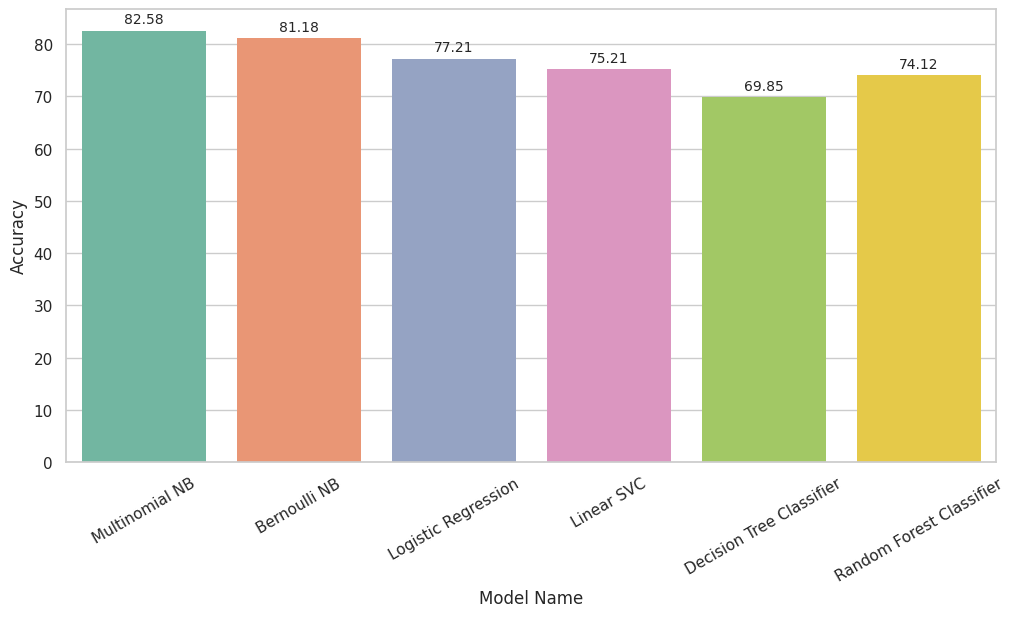

In [133]:
create_barplot(df_val,'Model Name','Accuracy','model_name','accuracy_score','count_ngram_val_accuracy')

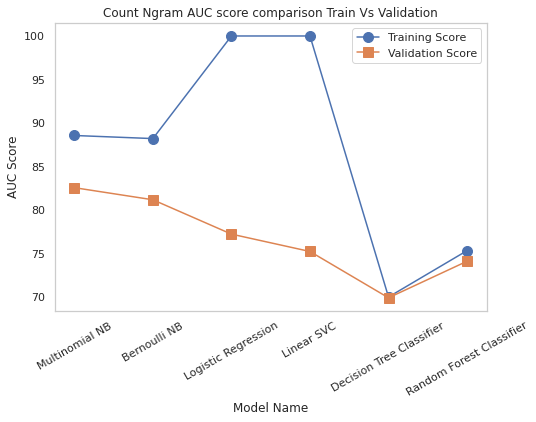

In [134]:
#Creating Canvas
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_ylabel('AUC Score')
ax.set_xlabel('Model Name')
ax.set_title('Count Ngram AUC score comparison Train Vs Validation')

#Creating Multiline Plot
ax.plot(model_name_list,training_auc_scores, label="Training Score",marker='o',ms=10)
ax.plot(model_name_list,validation_auc_scores, label="Validation Score",marker='s',ms=10)

ax.grid(False)
ax.set_facecolor('white')
ax.legend()
ax.tick_params(axis='x', rotation=30)
plt.show()
plt.close()

#### ANN 

In [135]:
tfidf_ann_vectorizer = TfidfVectorizer(min_df=0.001)

In [136]:
# fitting the ann_vectorizer to the train and validation data
features_train = tfidf_ann_vectorizer.fit_transform(X_train['review'])
features_validation = tfidf_ann_vectorizer.transform(X_val['review'])

In [137]:
# converting the features_train and features_validation
features_train = torch.tensor(features_train.toarray(),dtype=torch.float32)
features_validation = torch.tensor(features_validation.toarray(),dtype=torch.float32)

In [138]:
# convert target variables into pytorch tensors
Y_train = torch.tensor(Y_train['polarity'].values)
Y_val = torch.tensor(Y_val['polarity'].values)

In [139]:
# create dataloader

train_dataset = TensorDataset(features_train,Y_train)
val_dataset = TensorDataset(features_validation,Y_val)

train_loader = DataLoader(train_dataset,batch_size=256,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=256,shuffle=True)

In [140]:
class ANNModel(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,dropout_rate):
        super(ANNModel,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size,output_size)
        self.fc3 = nn.Sigmoid()
    
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [141]:
model = ANNModel(input_size=features_train.shape[1],hidden_size=64,output_size=1, dropout_rate=0.5)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

Epoch 1/6, Loss: 0.6873, Val Loss: 0.6765
Epoch 2/6, Loss: 0.6538, Val Loss: 0.6375
Epoch 3/6, Loss: 0.5948, Val Loss: 0.5862
Epoch 4/6, Loss: 0.5271, Val Loss: 0.5313
Epoch 5/6, Loss: 0.4601, Val Loss: 0.4870
Epoch 6/6, Loss: 0.4029, Val Loss: 0.4569


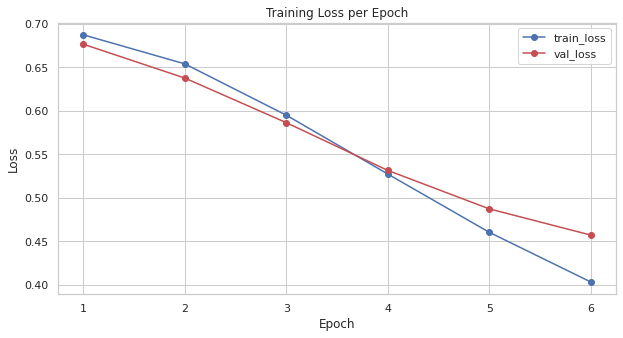

In [142]:
import matplotlib.pyplot as plt

num_epochs = 6  # Number of epochs
losses = []  # List to store the average loss per epoch
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0  # Variable to store the total loss in each epoch
    total_val_loss = 0
    count = 0  # Variable to count the number of batches
    val_count = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Squeeze the output to match the label's shape
        loss = criterion(outputs, labels.float())  # Ensure labels are float
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
    average_loss = total_loss / count  # Calculate average loss for the epoch
    losses.append(average_loss)  # Append average loss to the list
       
    for inputs, labels in val_loader:
        val_outputs = model(inputs)
        val_outputs = val_outputs.squeeze()  # Squeeze the output to match the label's shape
        val_loss = criterion(val_outputs, labels.float())  # Ensure labels are float
        total_val_loss += val_loss.item()
        val_count += 1
    average_val_loss = total_val_loss / val_count  # Calculate average loss for the epoch
    val_losses.append(average_val_loss)  # Append average loss to the list
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b', label = 'train_loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='o', linestyle='-', color='r', label = 'val_loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
def calculate_accuracy(loader):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = outputs.squeeze() > 0.5  # Apply threshold to convert probabilities to binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

train_accuracy = calculate_accuracy(train_loader)
val_accuracy = calculate_accuracy(val_loader)

print(f'Training Accuracy: {train_accuracy}%')
print(f'Validation Accuracy: {val_accuracy}%')

Training Accuracy: 90.17910447761194%
Validation Accuracy: 81.63636363636364%
